In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

2024-06-25 18:11:58.089456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 18:11:58.812460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_files(folder):
    filenames = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".png") and "imgs" in root:
                filenames.append(os.path.join(root, file))
    return filenames

In [3]:
files = get_files("data/")
train_paths = [(path, path.replace("imgs", "targets")) for path in files if "train" in path]
test_paths = [(path, path.replace("imgs", "targets")) for path in files if "test" in path]
val_paths = [(path, path.replace("imgs", "targets")) for path in files if "valid" in path]

print(train_paths[0])

print("Number of training samples: ", len(train_paths), 
      "\nNumber of validation samples: ", len(val_paths),
      "\nNumber of test samples: ", len(test_paths))

('data/train/imgs/HIP_0318.png', 'data/train/targets/HIP_0318.png')
Number of training samples:  320 
Number of validation samples:  91 
Number of test samples:  47


In [4]:
def normalize_image(image):
    image = tf.cast(image, tf.float32) - tf.reduce_mean(image)
    image = image / tf.math.reduce_std(image)
    return image

def normalize_mask(mask):
    mask = tf.cast(mask, tf.float32)
    mask = mask / 255.0
    return mask

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, IMSIZE)
    return image


def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMSIZE)
    return mask

def load_image_pair(image_path):
    image = load_image(image_path[0])
    mask = load_mask(image_path[1])
    image = normalize_image(image)
    mask = normalize_mask(mask)
    return image, mask

import tensorflow.keras.backend as K
@tf.function
def dice(y_true, y_pred):
    """Computes the Dice loss value between `y_true` and `y_pred`.

    Formula:
    ```python
    loss = 1 - (2 * sum(y_true * y_pred)) / (sum(y_true) + sum(y_pred))
    ```

    Args:
        y_true: tensor of true targets.
        y_pred: tensor of predicted targets.

    Returns:
        Dice loss value.
    """
    y_true = K.cast(y_true, y_pred.dtype)

    inputs = K.flatten(y_true)
    targets = K.flatten(y_pred)
    
    intersection = K.sum(inputs * targets)
    dice = tf.divide(
        2.0 * intersection,
        K.sum(y_true) + K.sum(y_pred) + K.epsilon(),
    )

    return 1 - dice

@tf.function
def dice_metric(y_true, y_pred):
    """Computes the Dice loss value between `y_true` and `y_pred`.

    Formula:
    ```python
    loss = 1 - (2 * sum(y_true * y_pred)) / (sum(y_true) + sum(y_pred))
    ```

    Args:
        y_true: tensor of true targets.
        y_pred: tensor of predicted targets.

    Returns:
        Dice loss value.
    """
    y_true = K.cast(y_true, y_pred.dtype)

    inputs = K.flatten(y_true)
    targets = K.flatten(y_pred)

    intersection = K.sum(inputs * targets)
    dice = tf.divide(
        2.0 * intersection,
        K.sum(y_true) + K.sum(y_pred) + K.epsilon(),
    )

    return dice

class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [5]:
# Create the dataset
BUFFER_SIZE = 100
BATCH_SIZE = 16
IMSIZE = (256, 256)

def create_dataset(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(load_image_pair, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    batches = (
        dataset
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        # .map(Augment(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return batches

train_batches = create_dataset(train_paths)
test_batches = create_dataset(test_paths)
val_batches = create_dataset(val_paths)

2024-06-25 18:11:59.875247: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-25 18:11:59.901188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-25 18:11:59.901417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Layer
from tensorflow.keras.models import Model

default_args = {
    "kernel_initializer": "he_normal",
    "padding": "same",
    "activation": "relu"
}

def unet(dropout_rate=0.2, lr=1e-3, init="he_normal", adam_beta1=0.9, adam_beta2=0.999):
    in1 = Input(shape=(*IMSIZE, 1))

    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=init, padding='same')(in1)
    conv1 = Dropout(dropout_rate)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(pool1)
    conv2 = Dropout(dropout_rate)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=init, padding='same')(pool2)
    conv3 = Dropout(dropout_rate)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=init, padding='same')(pool3)
    conv4 = Dropout(dropout_rate)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(up1)
    conv5 = Dropout(dropout_rate)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv5)

    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(up2)
    conv6 = Dropout(dropout_rate)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=init, padding='same')(up2)
    conv7 = Dropout(dropout_rate)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=init, padding='same')(conv7)
    segmentation = Conv2D(1, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=adam_beta1, beta_2=adam_beta2),
                  loss = dice,
                  metrics=['accuracy', dice_metric])
    return model

In [7]:
#model = get_second_model(dropout=0.3, lr=4e-4, init="he_normal")
#model.summary()

In [8]:
#history = model.fit(train_batches,
#                    validation_data=val_batches,
#                    epochs=150,
#                    verbose=2)

In [9]:
# for images, masks in test_batches.take(1):
#     predictions = model.predict(images)
#     fig, axs = plt.subplots(3, 3, figsize=(15, 15))
#     for ii, (img, msk, prediction) in enumerate(zip(images, masks, predictions)):
#         axs[ii, 0].imshow(img, cmap='gray')
#         axs[ii, 1].imshow(msk, cmap='gray')
#         axs[ii, 2].imshow(prediction, cmap='gray')
#         axs[ii, 0].axis("off")
#         axs[ii, 1].axis("off")
#         axs[ii, 2].axis("off")
#         axs[ii, 0].set_title("Image")
#         axs[ii, 1].set_title("Mask")
#         axs[ii, 2].set_title("Prediction")
#         if ii == 2:
#             break

# fig, axs = plt.subplots(1, 2)
# axs[0].plot(history.history['loss'])
# axs[0].plot(history.history['val_loss'])
# axs[1].plot(history.history['dice_metric'])
# axs[1].plot(history.history['val_dice_metric'])
# axs[0].set_title('Model loss')
# axs[0].set_ylabel('Loss')
# axs[0].set_xlabel('Epoch')
# axs[0].legend(['Train', 'Val'], loc='upper left')
# axs[1].set_title('Model accuracy')
# axs[1].set_ylabel('Accuracy')
# axs[1].set_xlabel('Epoch')
# axs[1].legend(['Train', 'Val'], loc='lower right')
# plt.show()

In [24]:
parameters={
    'init': ['he_normal', 'glorot_uniform'],
    'dropout_rate': [0.2, 0.3, 0.5],
    'adam_beta1': [i / 10 for i in range(1,10)],
    'adam_beta2': [0.990 + 10 * i / 10000 for i in range(1,10)]
}

In [11]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# def create_model(lr=0.001, init='he_normal', dropout_rate= 0.1, adam_beta1=0.9, adam_beta2=0.999):
#     return KerasClassifier(
#         build_fn=get_second_model, 
#         lr=lr,
#         init=init, 
#         dropout_rate=dropout_rate,
#         adam_beta1=adam_beta1,
#         adam_beta2=adam_beta2,
#         epochs=150, 
#         batch_size=32, 
#         verbose=0#
#     )

# random_search = RandomizedSearchCV(estimator=get_second_model(), param_distributions=parameters, n_iter=10, cv=3, verbose=1)
# x_train = np.concatenate([x for x, _ in train_batches], axis=0)
# y_train = np.concatenate([y for _, y in train_batches], axis=0)
# for x, y in train_batches:
#     print(x.shape)
#     print(y.shape)
#     break
# print(x_train.shape)
# print(y_train.shape)

# random_search_result = random_search.fit(x_train, y_train)

In [12]:
determine_learning_rate = True
learning_rate_results = {}

if determine_learning_rate:
    # determine learning rate
    for learning_rate in [10 ** -i for i in range(3,6)]:
        for multiplier in range(10):
            lr = learning_rate * (multiplier + 1)
            model = unet()
            history = model.fit(train_batches,
                            validation_data=val_batches,
                            epochs=10,
                            verbose=2)
            learning_rate_results[lr] = max(history.history['val_dice_metric'])


Epoch 1/10


I0000 00:00:1719331931.311378 1085085 service.cc:145] XLA service 0x7f08ec002380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719331931.311450 1085085 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-06-25 18:12:11.484870: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-25 18:12:11.846924: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1719331958.413519 1085085 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 - 40s - 2s/step - accuracy: 0.4784 - dice_metric: 0.1883 - loss: 0.8117 - val_accuracy: 0.4720 - val_dice_metric: 0.2038 - val_loss: 0.7953
Epoch 2/10
20/20 - 2s - 125ms/step - accuracy: 0.7259 - dice_metric: 0.2766 - loss: 0.7234 - val_accuracy: 0.8103 - val_dice_metric: 0.3609 - val_loss: 0.6393
Epoch 3/10
20/20 - 2s - 125ms/step - accuracy: 0.8707 - dice_metric: 0.4112 - loss: 0.5888 - val_accuracy: 0.9003 - val_dice_metric: 0.4741 - val_loss: 0.5263
Epoch 4/10
20/20 - 3s - 125ms/step - accuracy: 0.9161 - dice_metric: 0.5251 - loss: 0.4749 - val_accuracy: 0.8509 - val_dice_metric: 0.4652 - val_loss: 0.5337
Epoch 5/10
20/20 - 3s - 125ms/step - accuracy: 0.9049 - dice_metric: 0.5245 - loss: 0.4755 - val_accuracy: 0.9390 - val_dice_metric: 0.6554 - val_loss: 0.3434
Epoch 6/10
20/20 - 3s - 126ms/step - accuracy: 0.9525 - dice_metric: 0.6999 - loss: 0.3001 - val_accuracy: 0.9715 - val_dice_metric: 0.8031 - val_loss: 0.1990
Epoch 7/10
20/20 - 2s - 124ms/step - accuracy: 0.9707 - dic

In [13]:
learning_rate_results
sorted_learning_rates = sorted(learning_rate_results.items(), key=lambda lr: lr[1], reverse=True)
print(sorted_learning_rates)

[(0.00030000000000000003, 0.9256102442741394), (0.007, 0.9177303314208984), (6.000000000000001e-05, 0.9161427021026611), (1e-05, 0.9146731495857239), (0.0004, 0.9113056063652039), (0.0006000000000000001, 0.9104962944984436), (0.0002, 0.9088618755340576), (0.0008, 0.9081816077232361), (8e-05, 0.905160129070282), (0.009000000000000001, 0.9047753810882568), (0.005, 0.904595673084259), (0.002, 0.9024979472160339), (0.004, 0.8978174328804016), (0.001, 0.8943246006965637), (0.003, 0.8875320553779602), (4e-05, 0.8862958550453186), (7.000000000000001e-05, 0.8838151097297668), (5e-05, 0.877230167388916), (0.0005, 0.8763424754142761), (0.0007, 0.874356210231781), (9e-05, 0.8726813793182373), (0.008, 0.8605783581733704), (0.0009000000000000001, 0.8536821007728577), (3.0000000000000004e-05, 0.7780080437660217), (0.0001, 0.7533032298088074), (0.01, 0.3393200933933258), (0.006, 0.14142200350761414), (2e-05, 0.1412336379289627)]


In [15]:
learning_rate, _ = sorted_learning_rates[0]
print(f"using learning rate: {learning_rate}")

using learning rate: 0.00030000000000000003


In [25]:
for param in parameters.items():
    print(param)

('init', ['he_normal', 'glorot_uniform'])
('dropout_rate', [0.2, 0.3, 0.5])
('adam_beta1', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
('adam_beta2', [0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999])


In [26]:
import itertools

# Extract the keys and values from the parameters dictionary
keys = parameters.keys()
values = parameters.values()

# Generate the Cartesian product of the parameter values
combinations = list(itertools.product(*values))

# Convert each combination into a dictionary
combinations_dicts = [dict(zip(keys, combo)) for combo in combinations]

# Example to print the first few combinations
for combo in combinations_dicts[:5]:
    print(combo)

print(len(combinations_dicts))

{'init': 'he_normal', 'dropout_rate': 0.2, 'adam_beta1': 0.1, 'adam_beta2': 0.991}
{'init': 'he_normal', 'dropout_rate': 0.2, 'adam_beta1': 0.1, 'adam_beta2': 0.992}
{'init': 'he_normal', 'dropout_rate': 0.2, 'adam_beta1': 0.1, 'adam_beta2': 0.993}
{'init': 'he_normal', 'dropout_rate': 0.2, 'adam_beta1': 0.1, 'adam_beta2': 0.994}
{'init': 'he_normal', 'dropout_rate': 0.2, 'adam_beta1': 0.1, 'adam_beta2': 0.995}
486


In [27]:
for combo in combinations_dicts:
    if 'history' in combo.keys():
        combo.pop('history')
    combo['lr'] = learning_rate
    model = unet(**combo)
    combo['history'] = model.fit(train_batches,
        validation_data=val_batches,
        epochs=50,
        verbose=2
    )

Epoch 1/50
20/20 - 15s - 745ms/step - accuracy: 0.5685 - dice_metric: 0.1798 - loss: 0.8202 - val_accuracy: 0.6806 - val_dice_metric: 0.2250 - val_loss: 0.7751
Epoch 2/50
20/20 - 3s - 126ms/step - accuracy: 0.5216 - dice_metric: 0.1947 - loss: 0.8053 - val_accuracy: 0.4874 - val_dice_metric: 0.2055 - val_loss: 0.7942
Epoch 3/50
20/20 - 3s - 126ms/step - accuracy: 0.7499 - dice_metric: 0.0992 - loss: 0.9008 - val_accuracy: 0.9240 - val_dice_metric: 3.4479e-17 - val_loss: 1.0000
Epoch 4/50
20/20 - 3s - 126ms/step - accuracy: 0.9217 - dice_metric: 8.6133e-06 - loss: 1.0000 - val_accuracy: 0.9240 - val_dice_metric: 6.1998e-17 - val_loss: 1.0000
Epoch 5/50
20/20 - 3s - 126ms/step - accuracy: 0.9216 - dice_metric: 9.5301e-06 - loss: 1.0000 - val_accuracy: 0.9240 - val_dice_metric: 9.9970e-17 - val_loss: 1.0000
Epoch 6/50
20/20 - 3s - 126ms/step - accuracy: 0.9216 - dice_metric: 2.3767e-05 - loss: 1.0000 - val_accuracy: 0.9240 - val_dice_metric: 1.0142e-15 - val_loss: 1.0000
Epoch 7/50
20/20 

In [28]:
d = combinations_dicts[0]
max((max(d['history'].history['val_dice_metric'] if 'history' in d.keys() else [-1])) for d in combinations_dicts)


0.9574781060218811

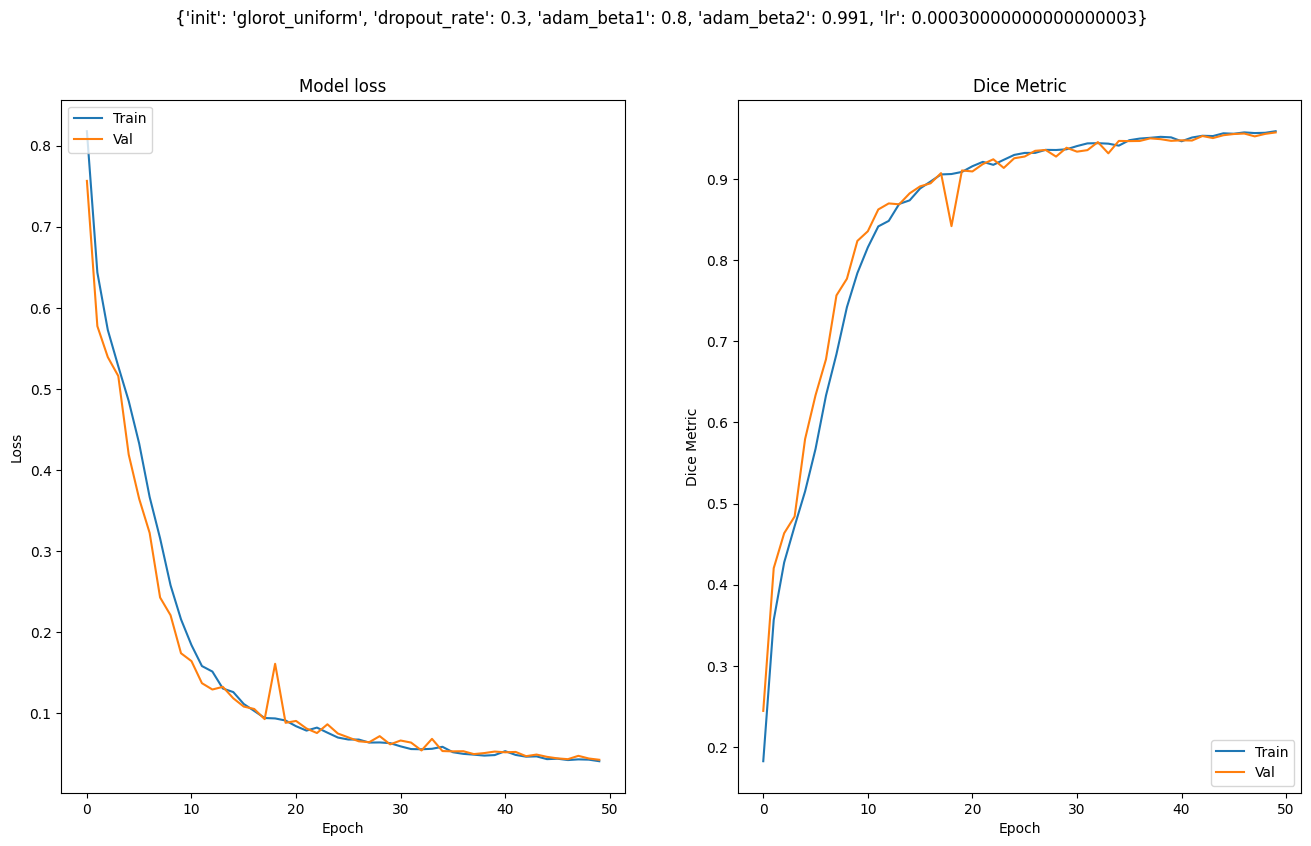

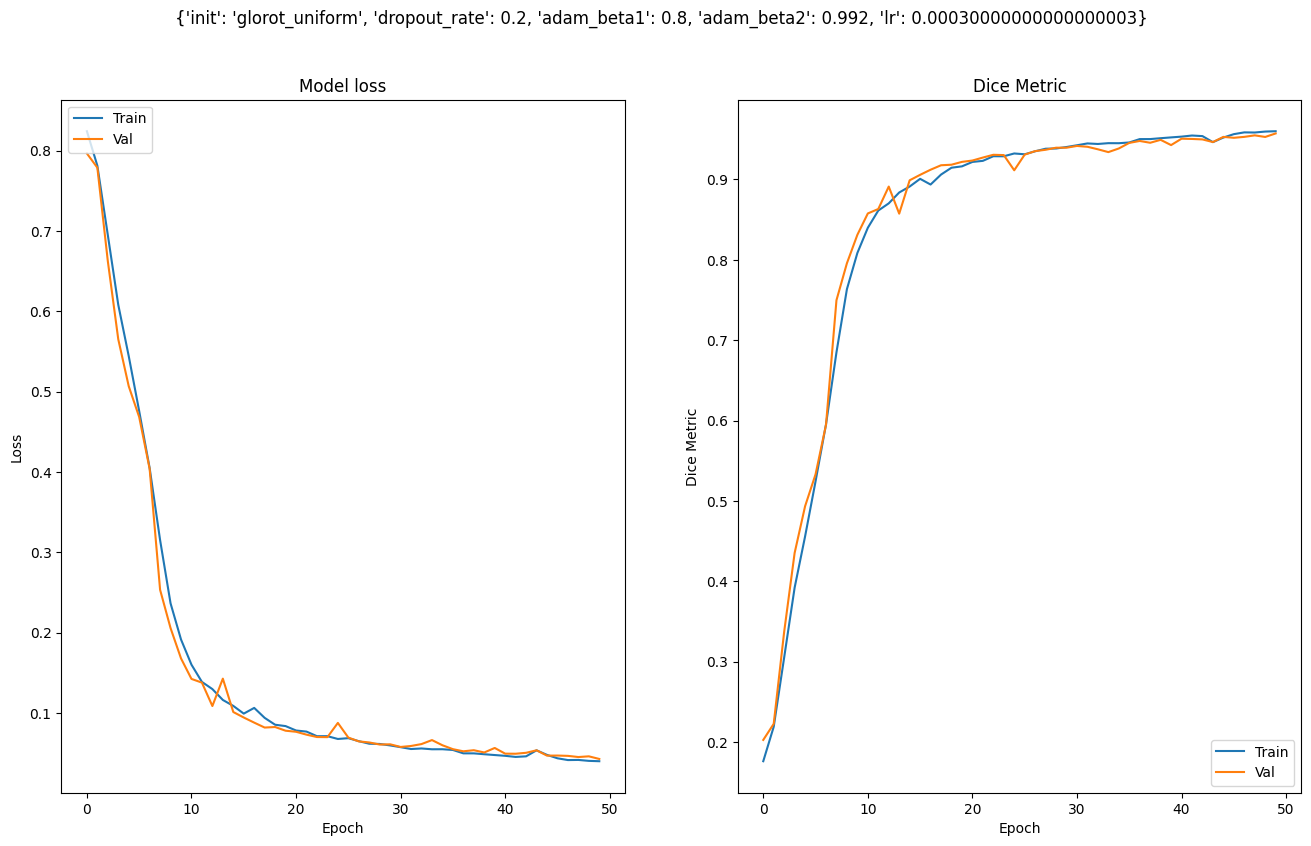

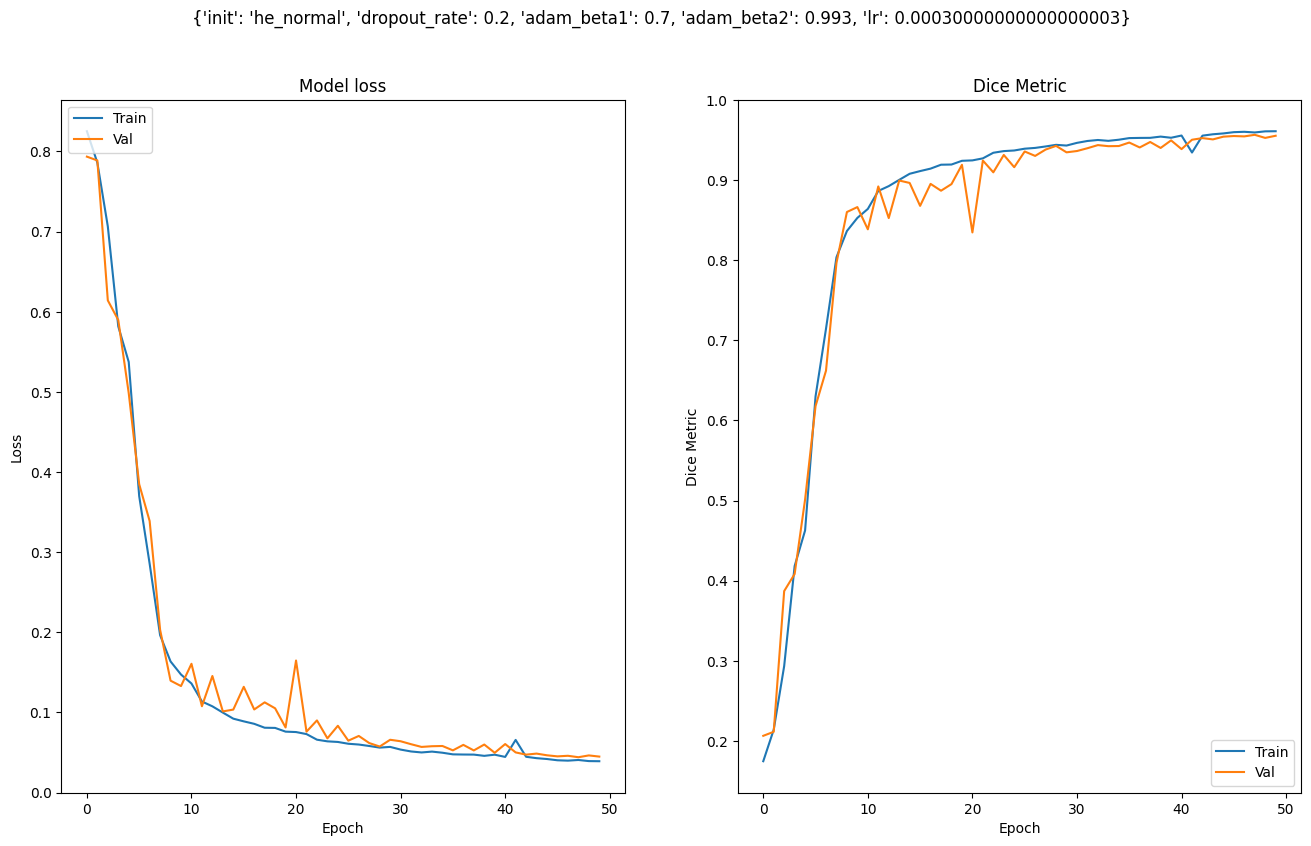

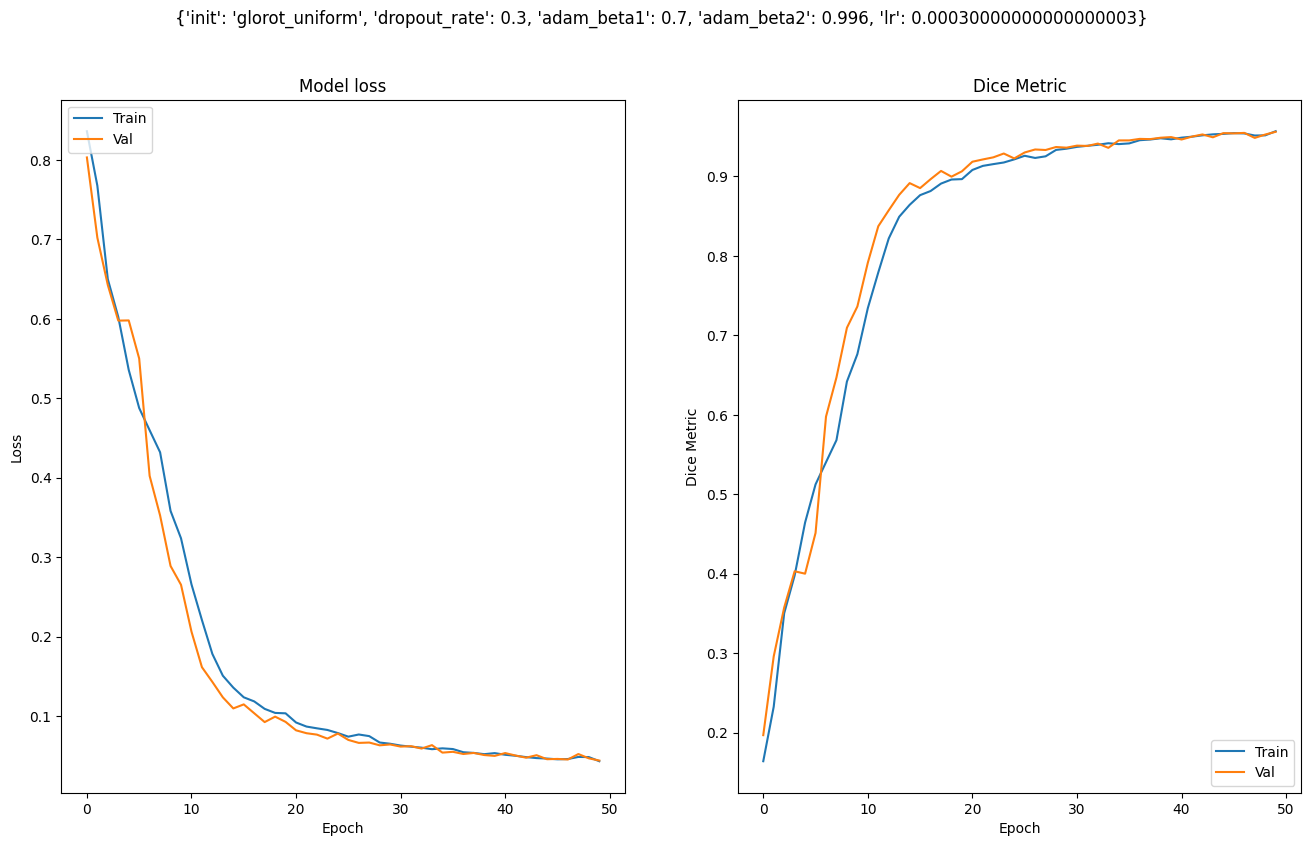

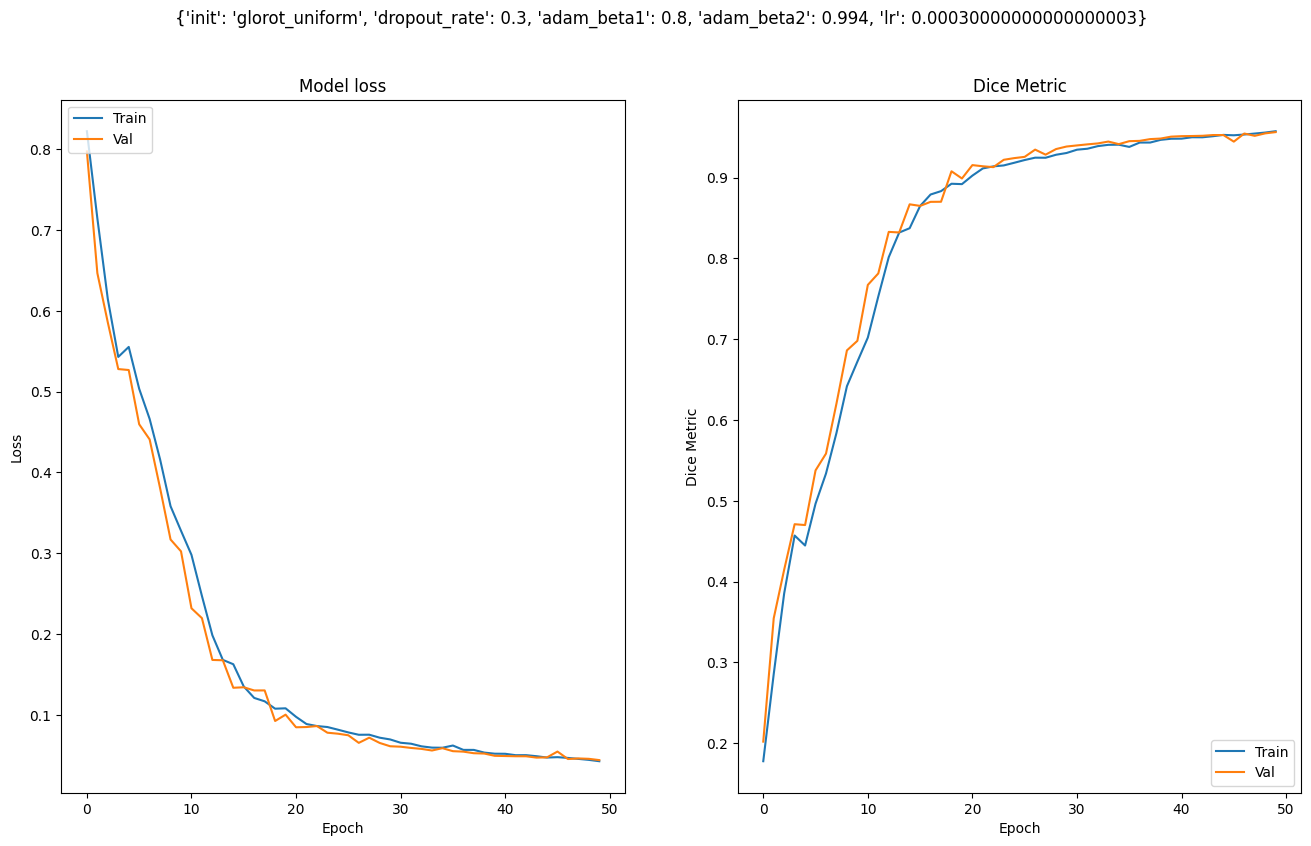

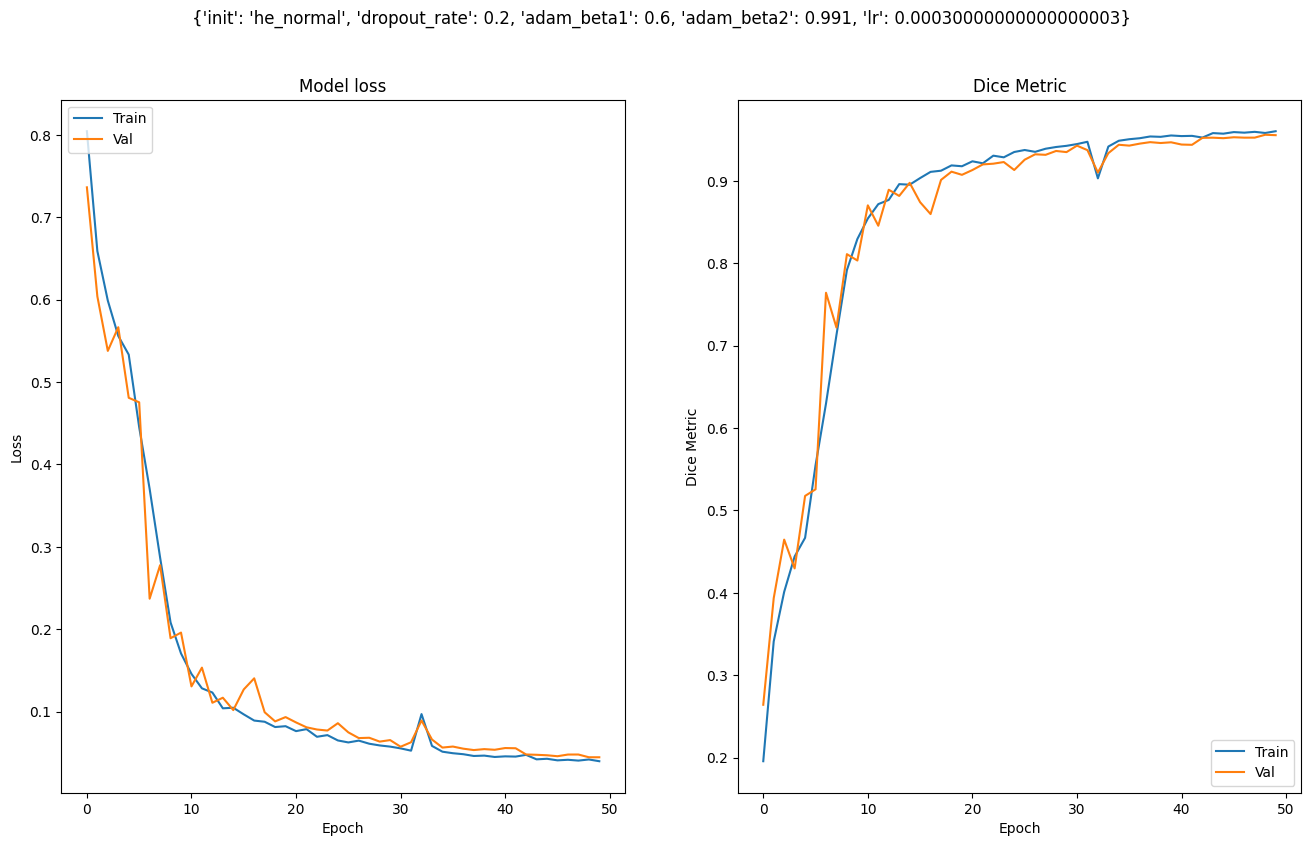

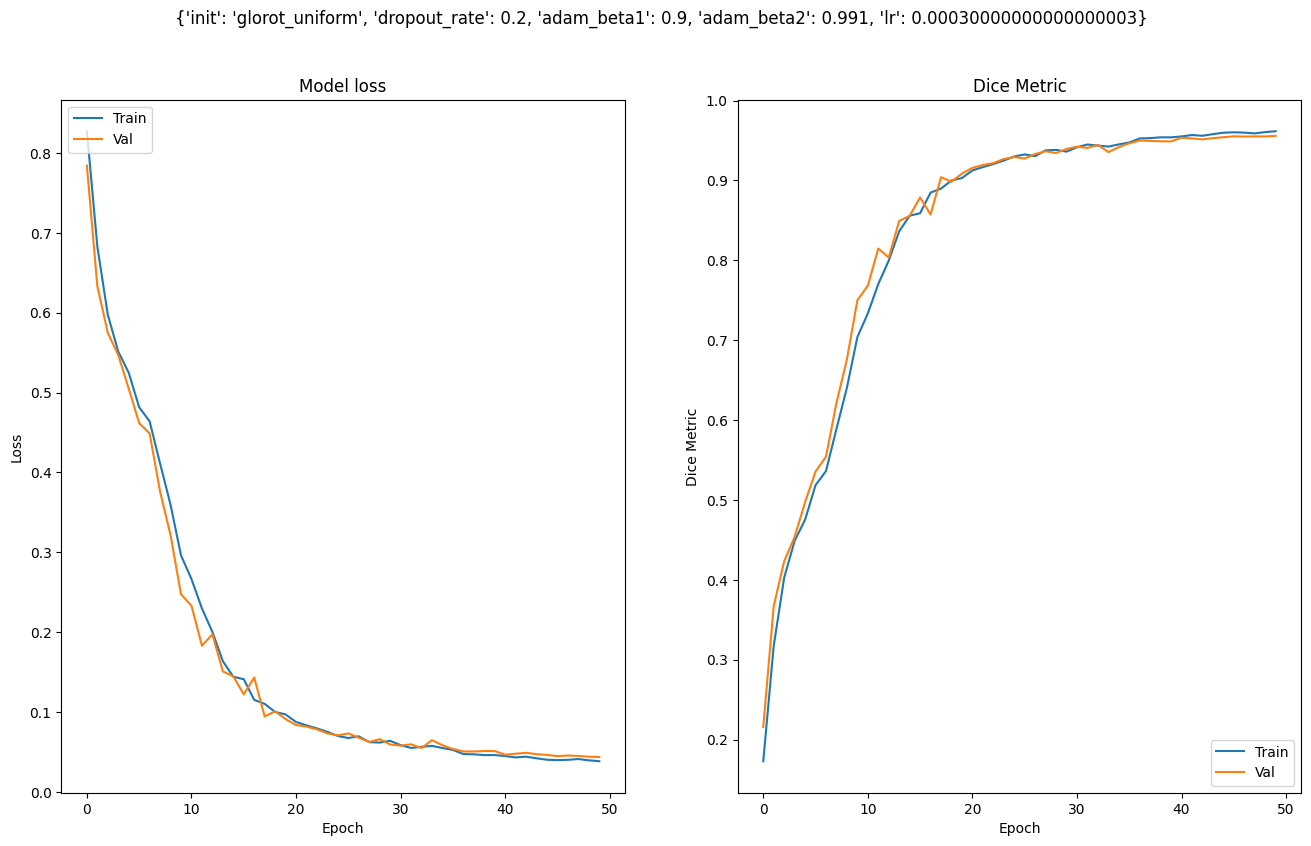

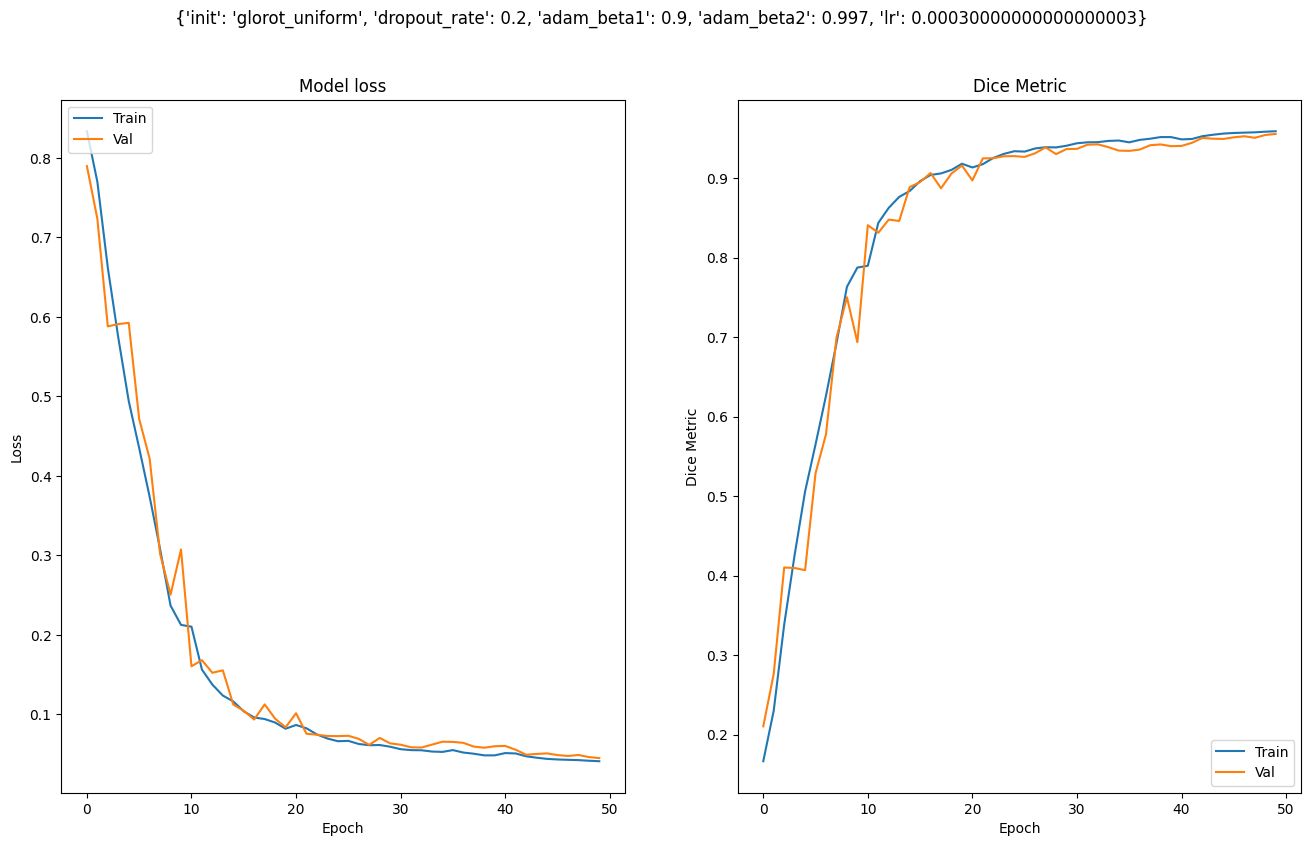

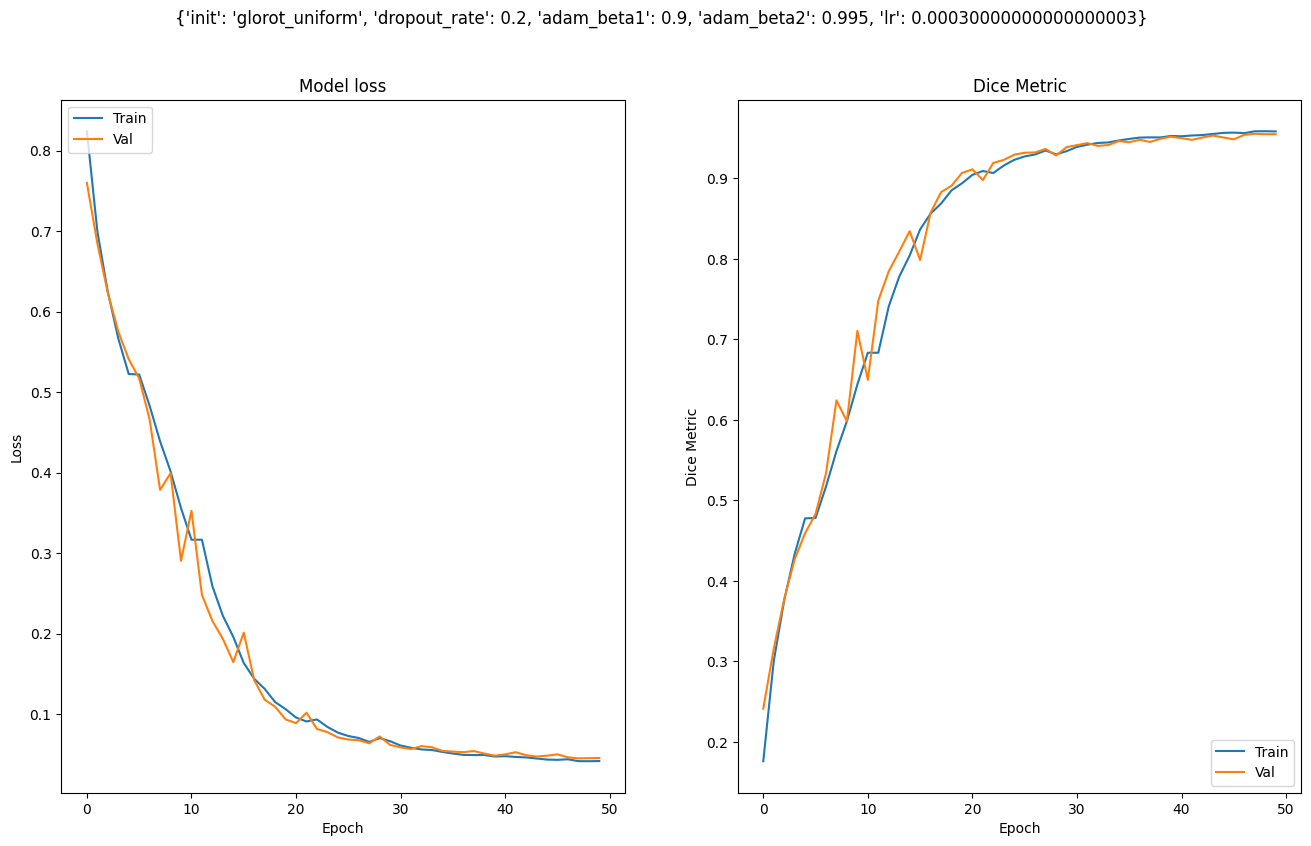

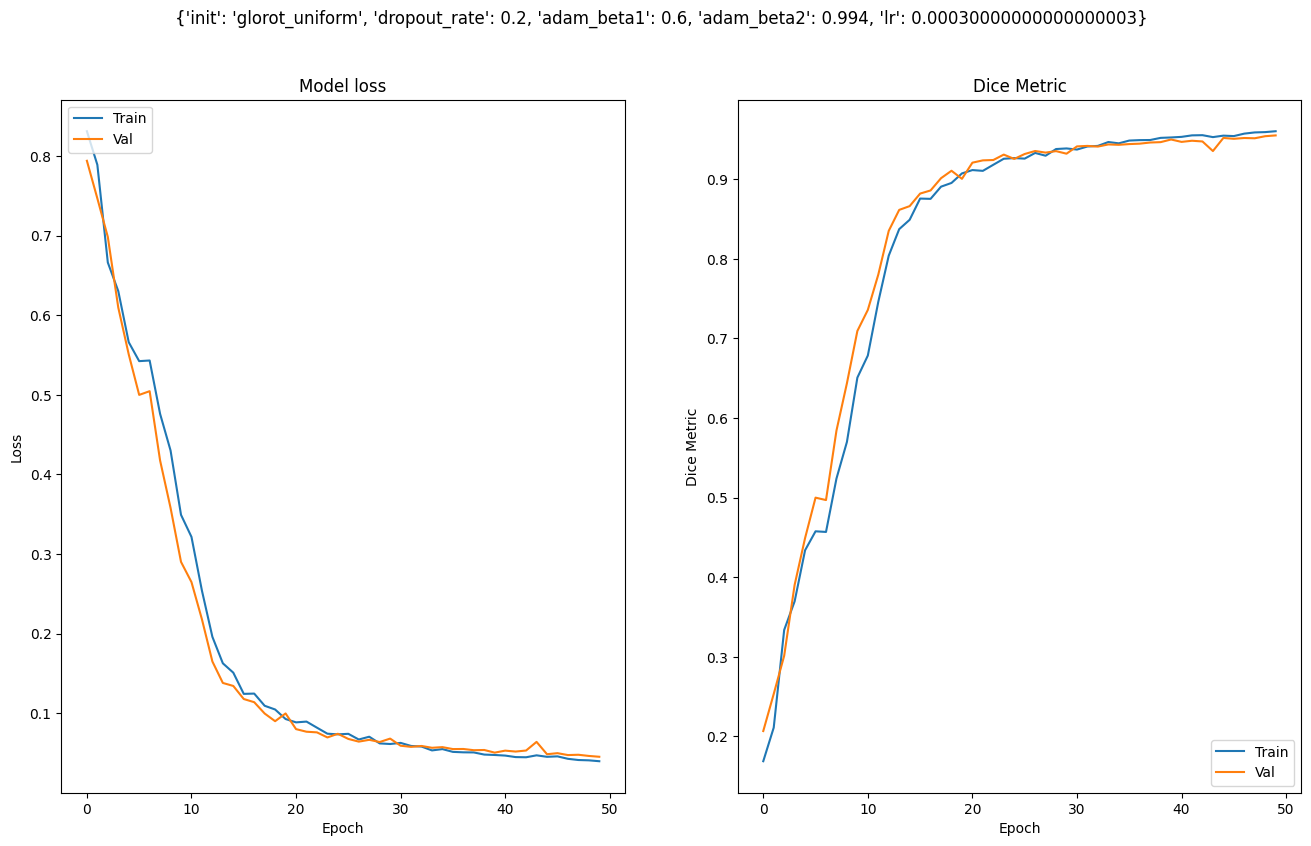

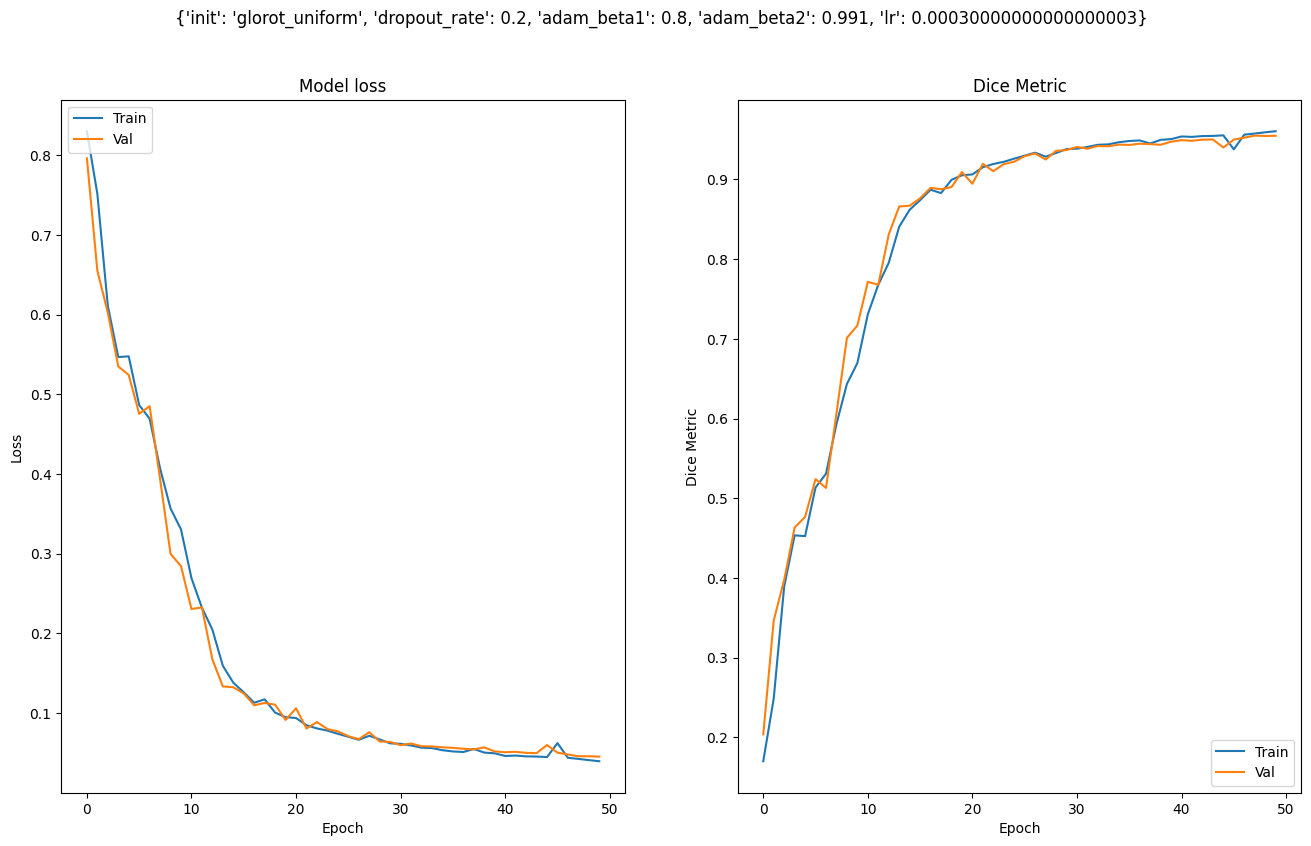

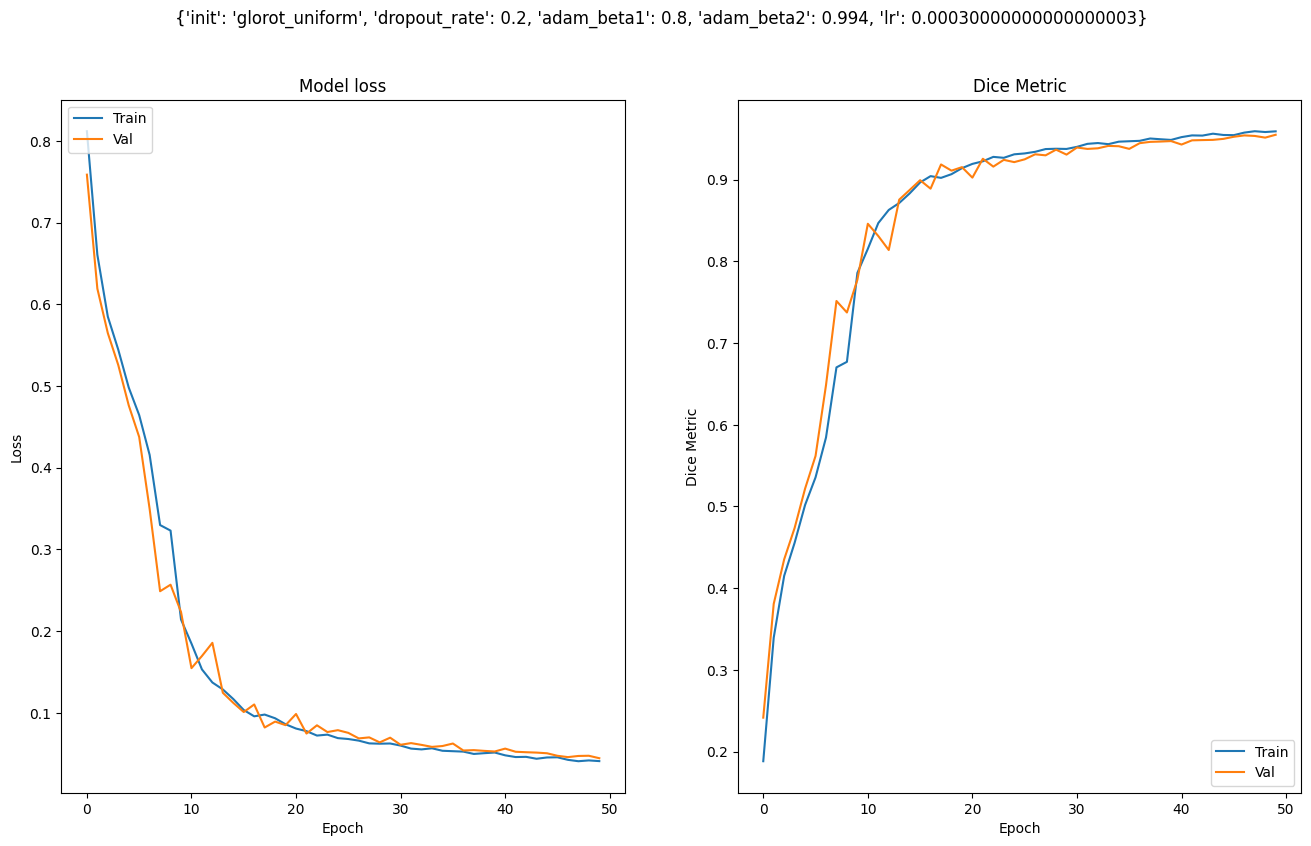

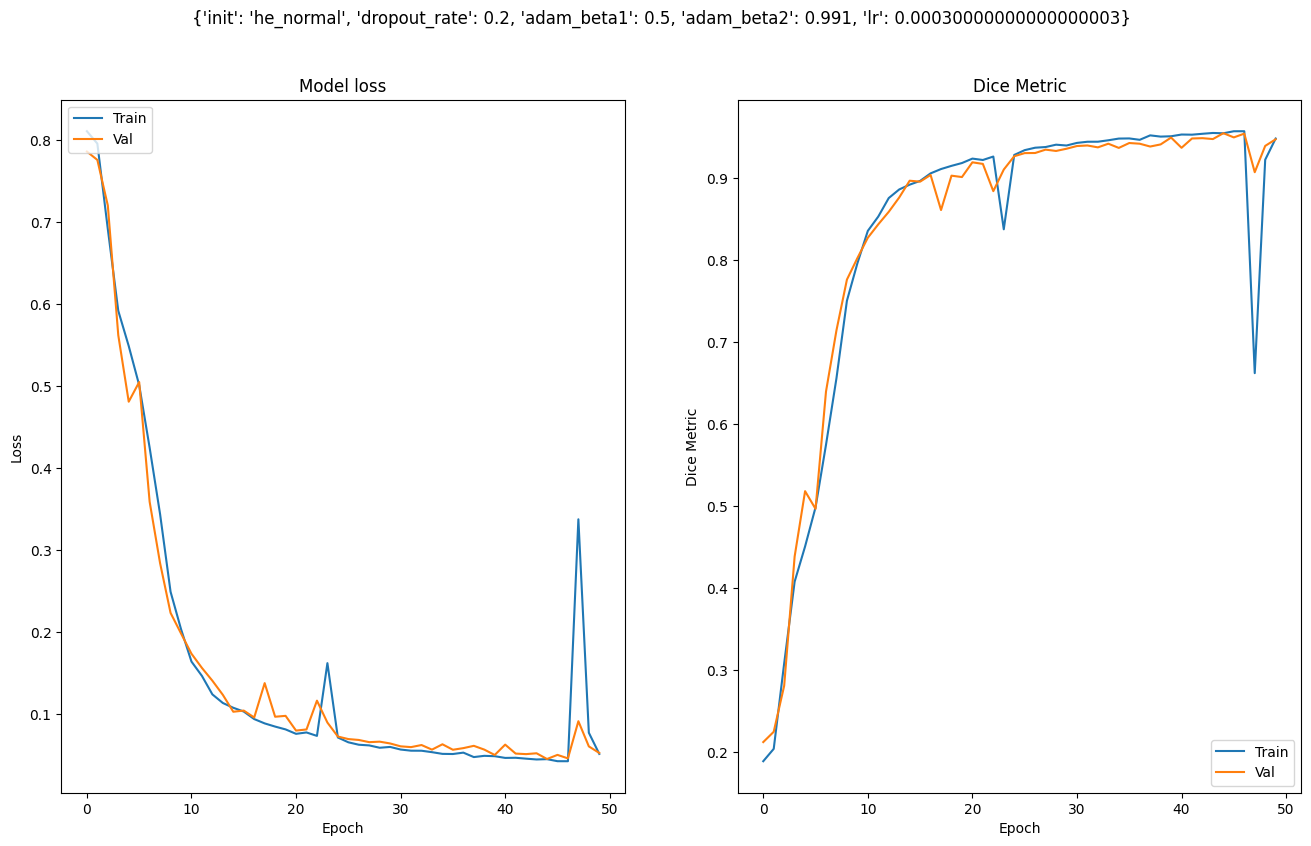

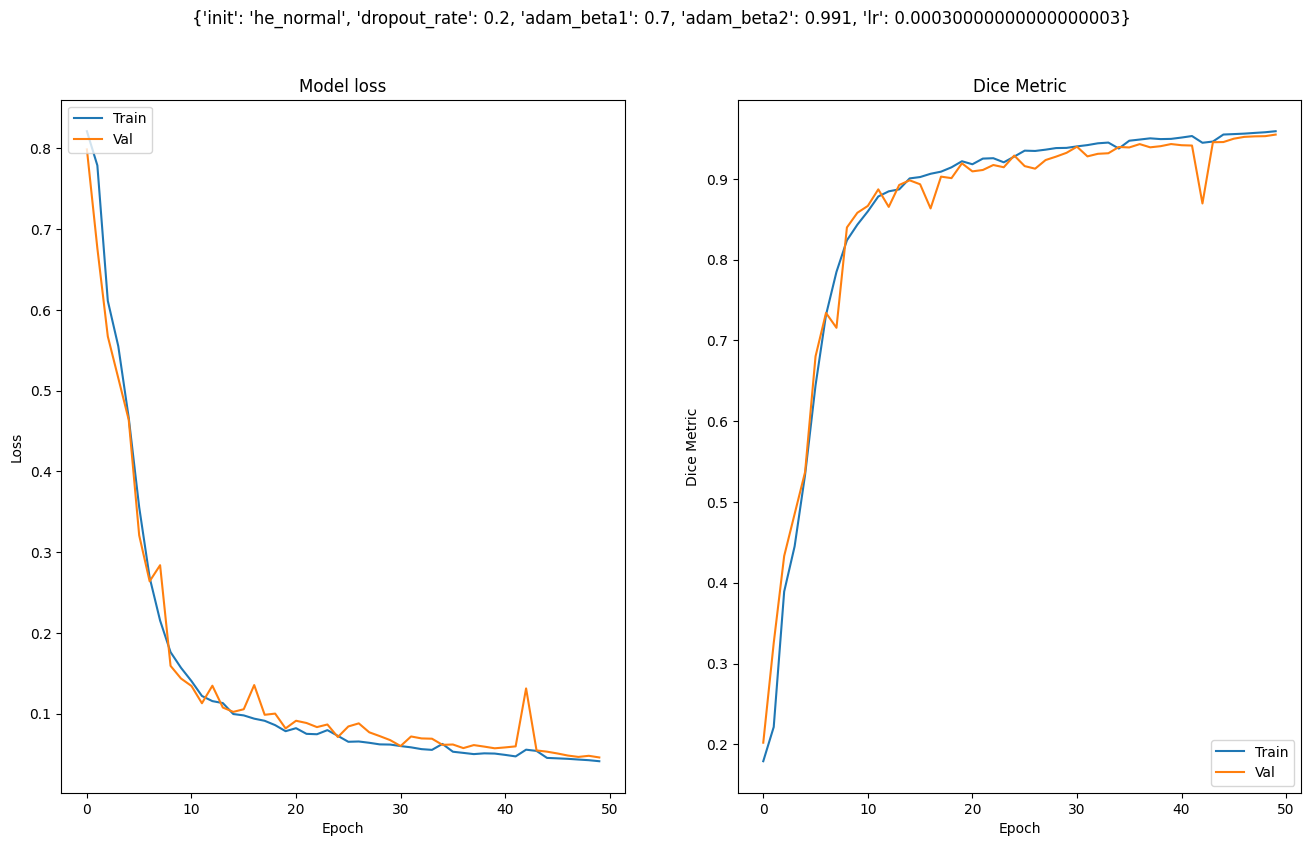

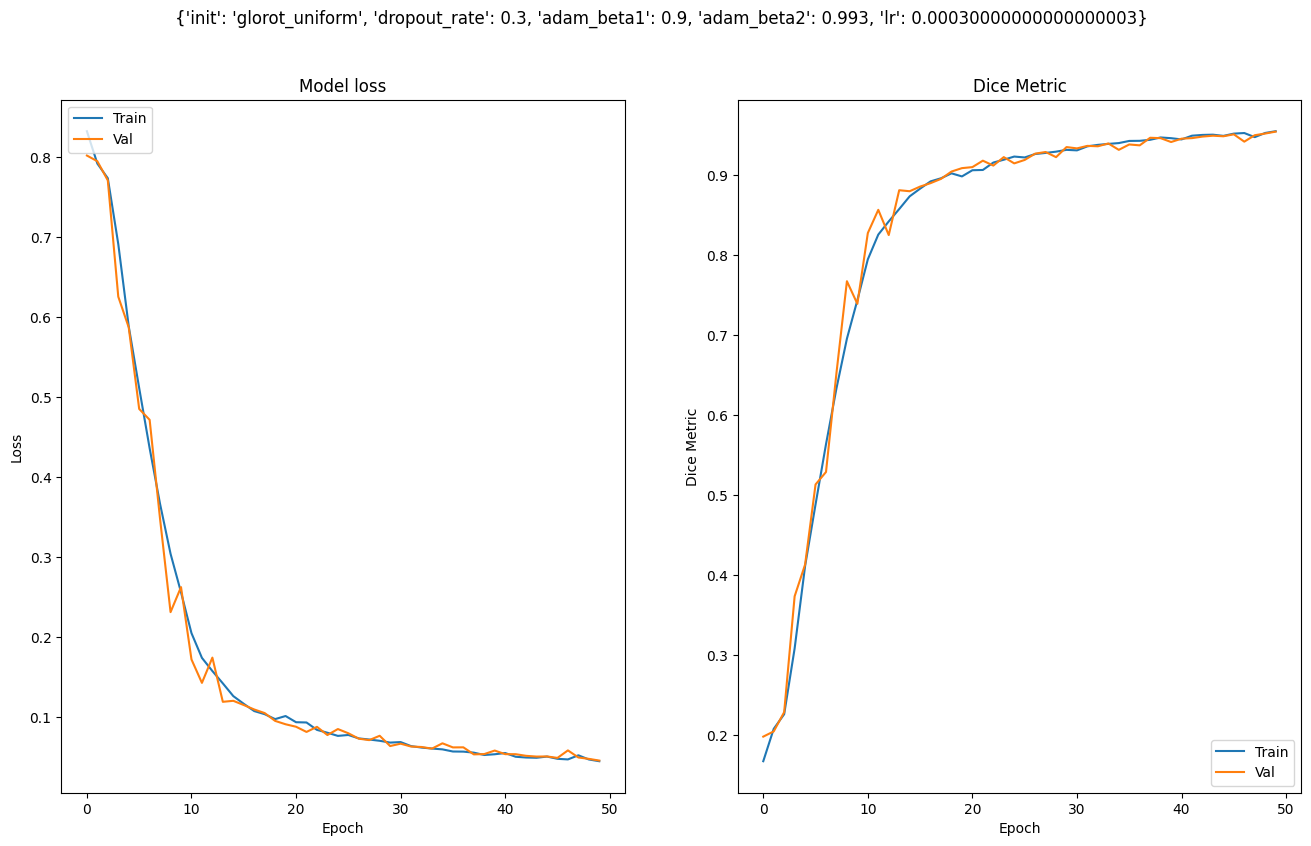

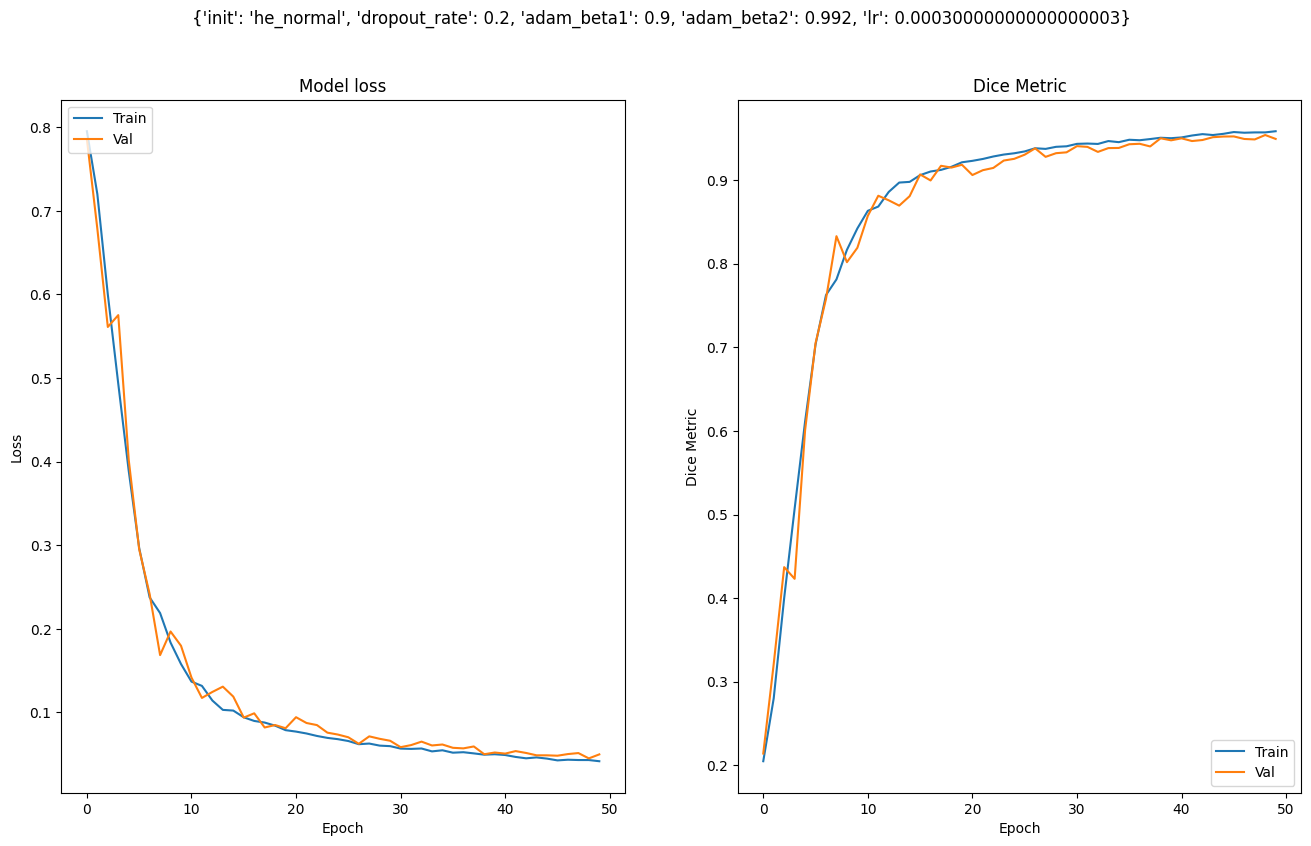

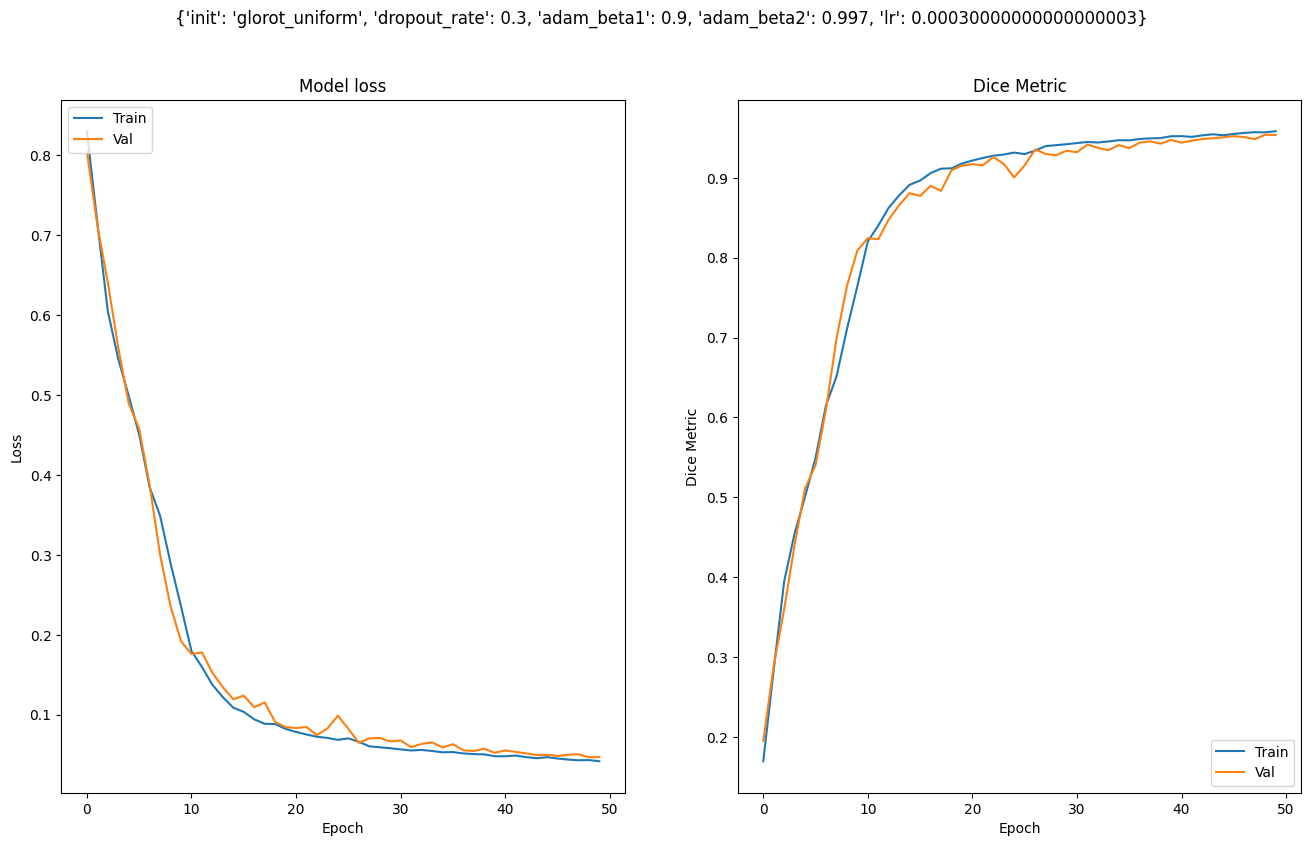

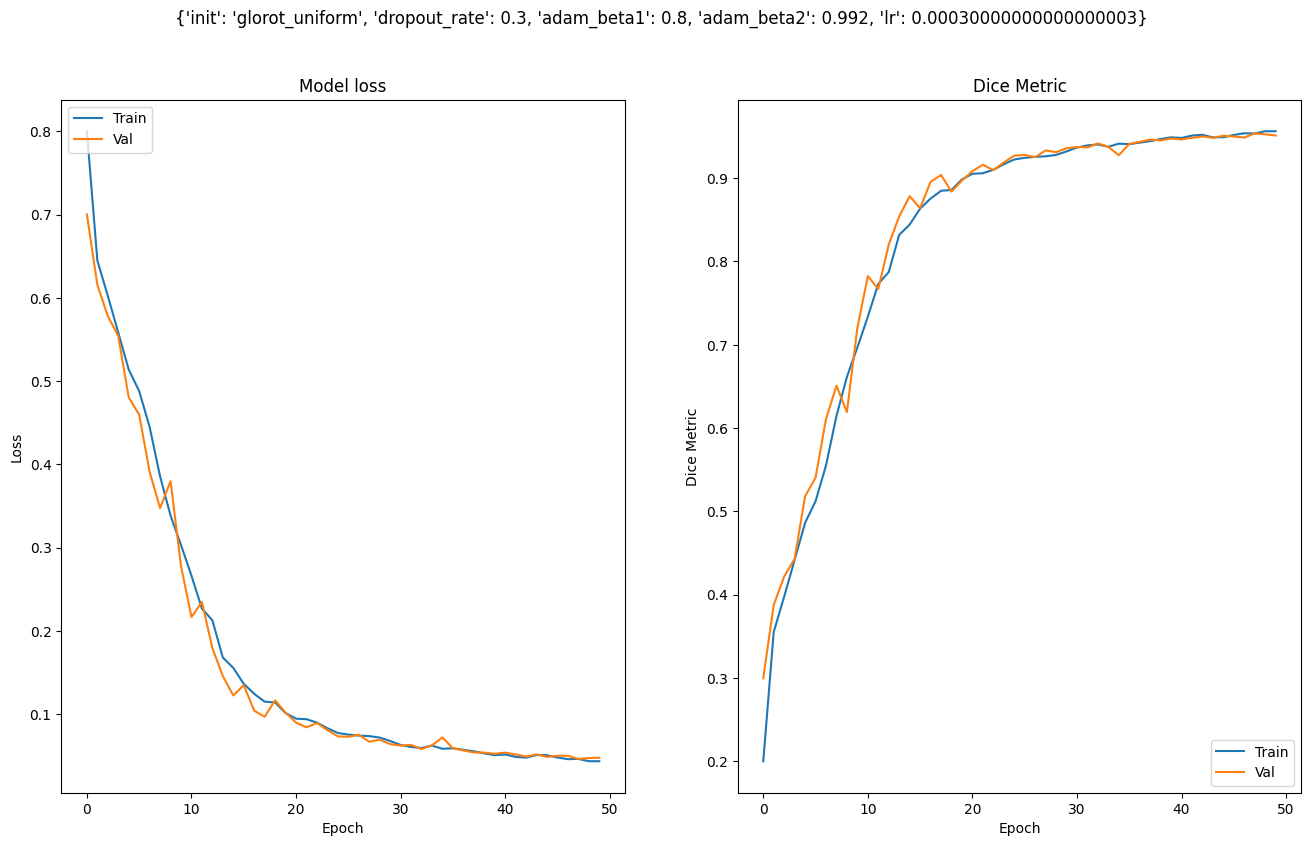

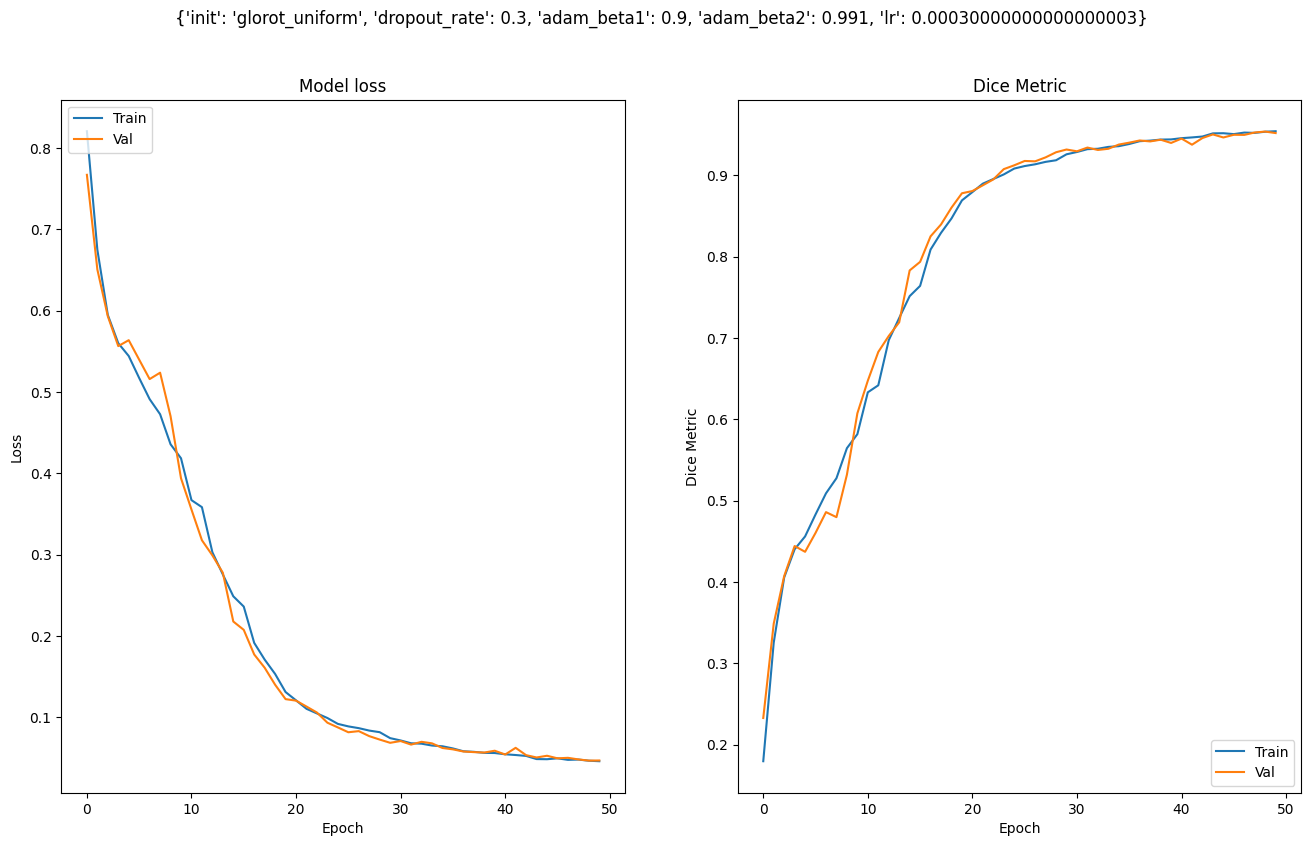

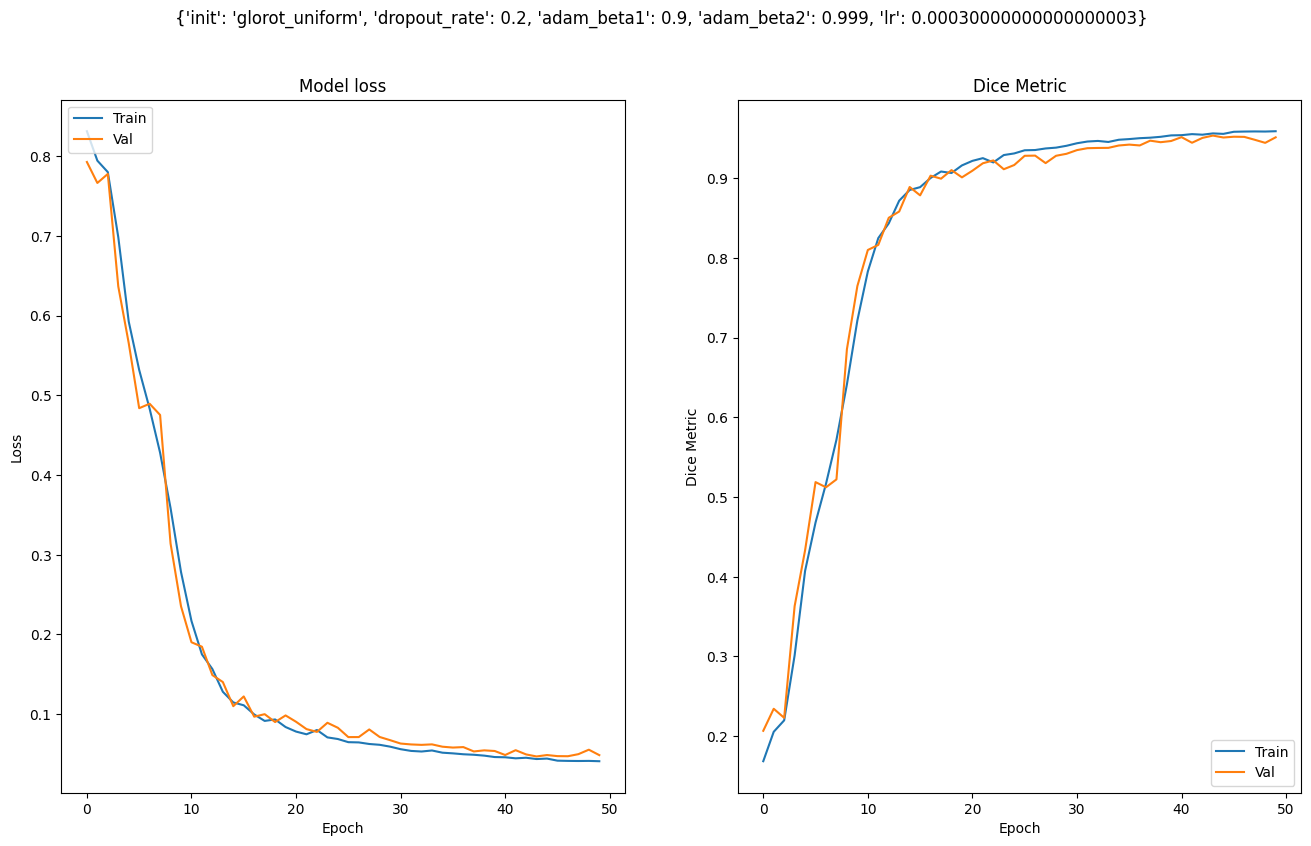

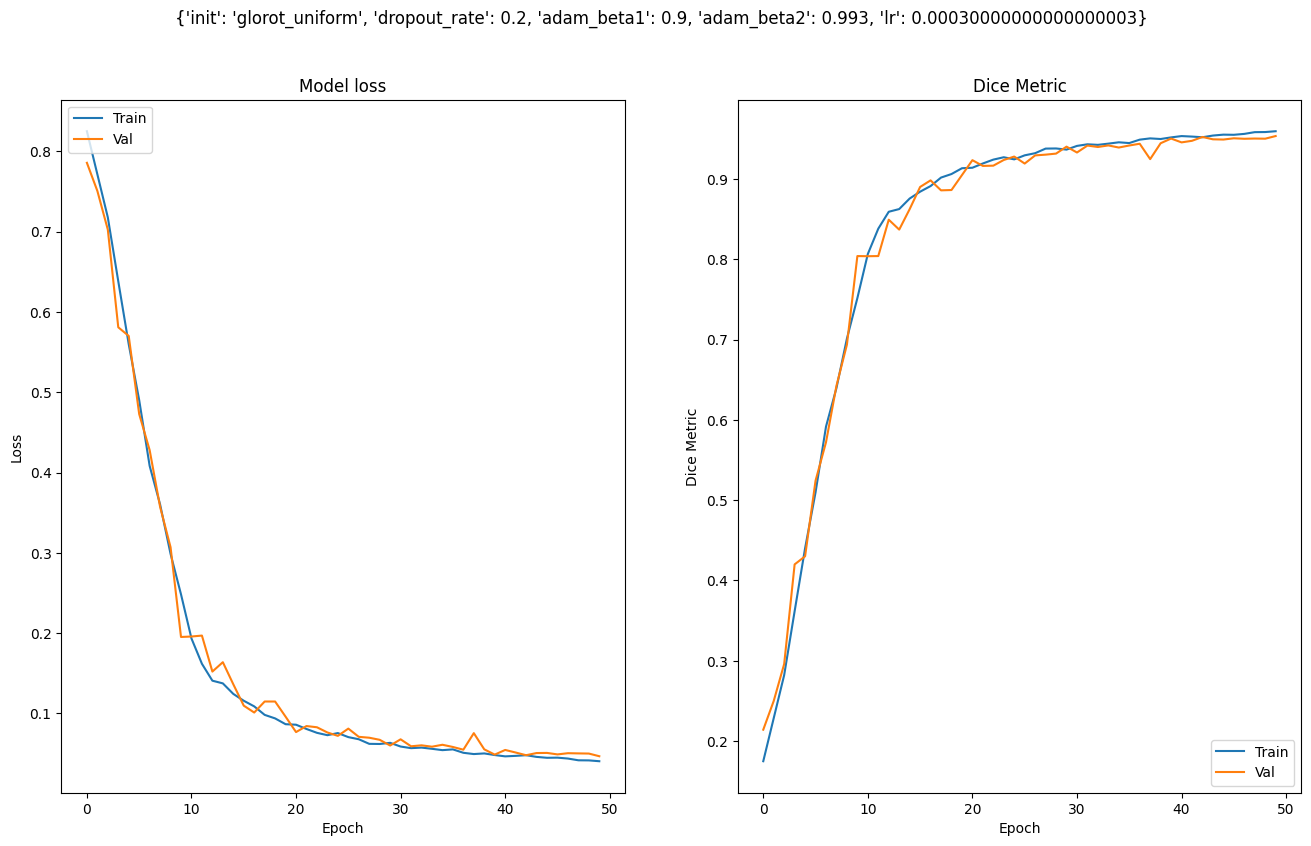

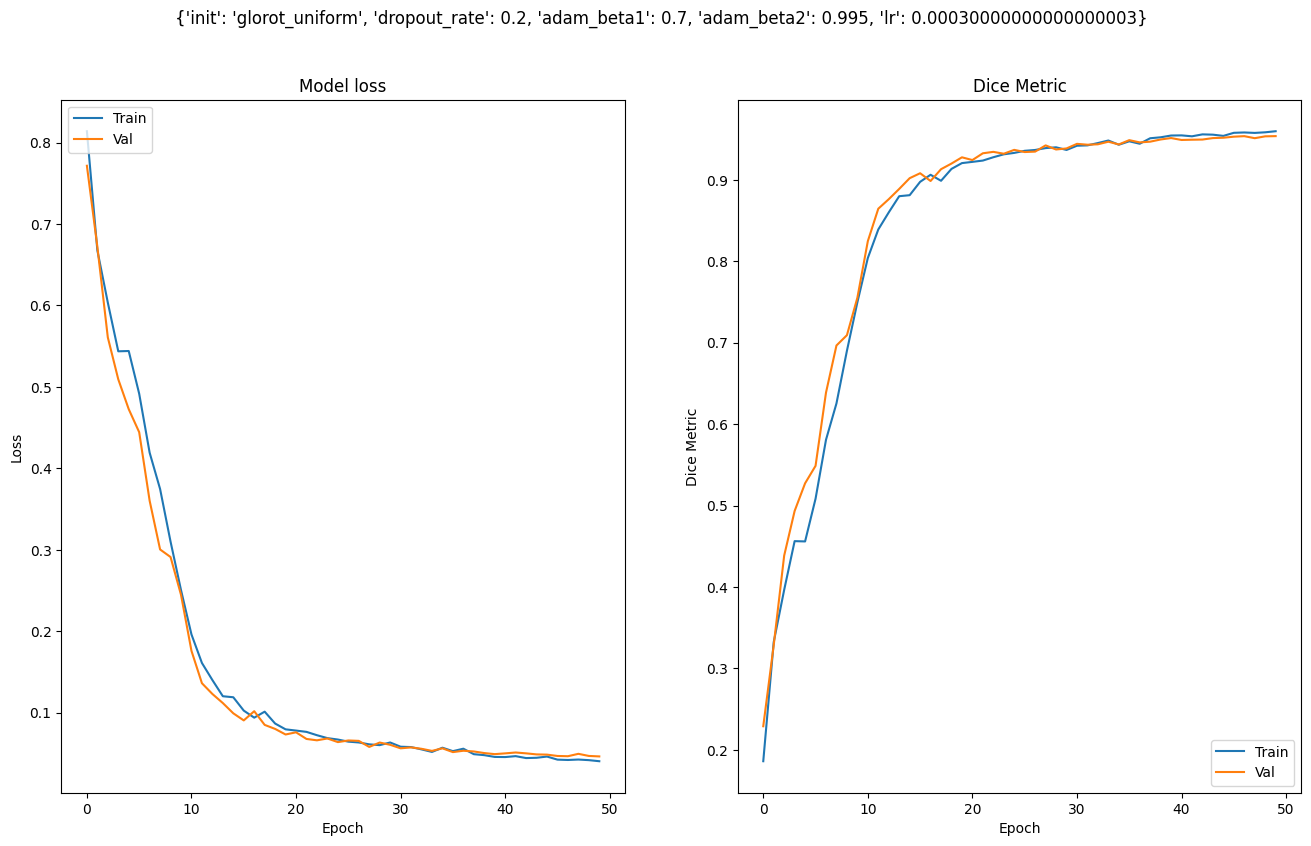

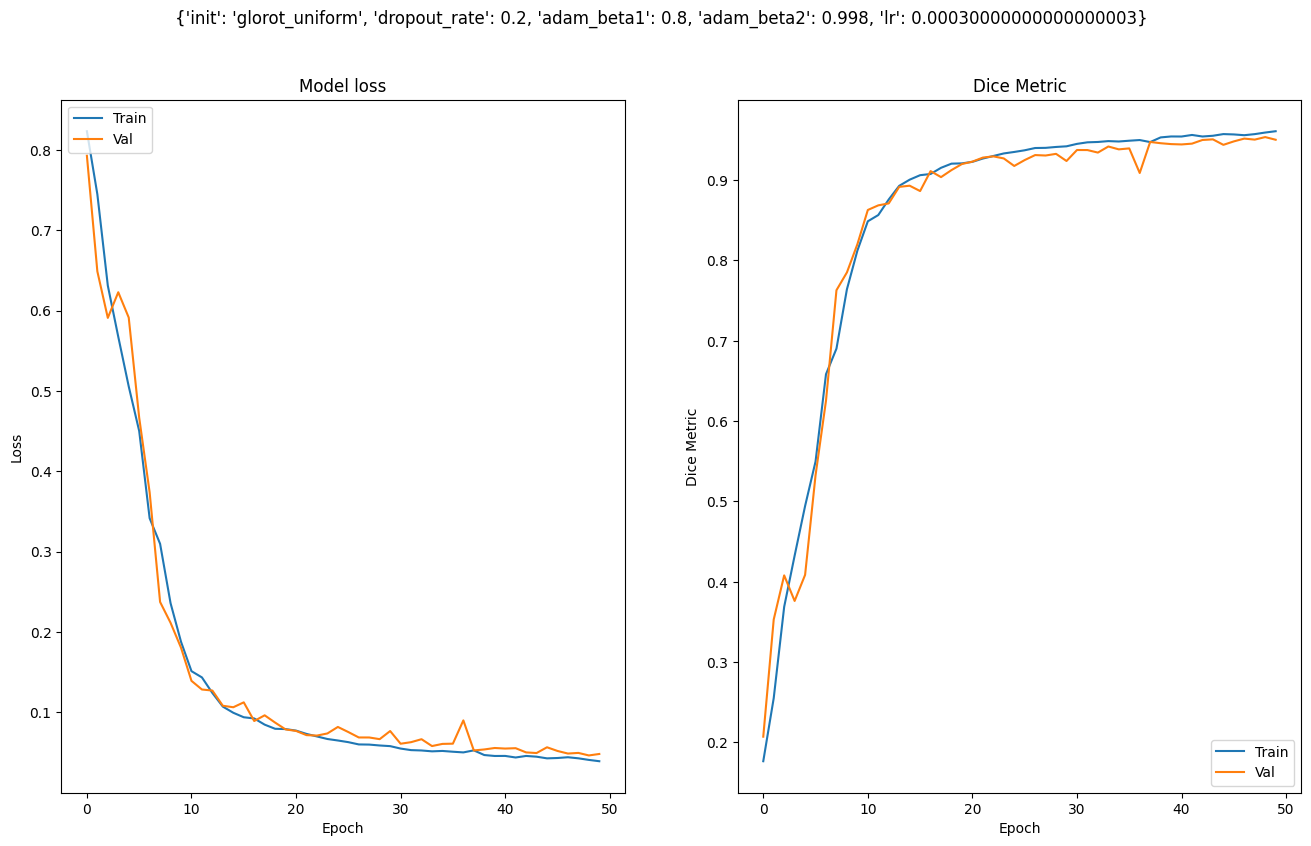

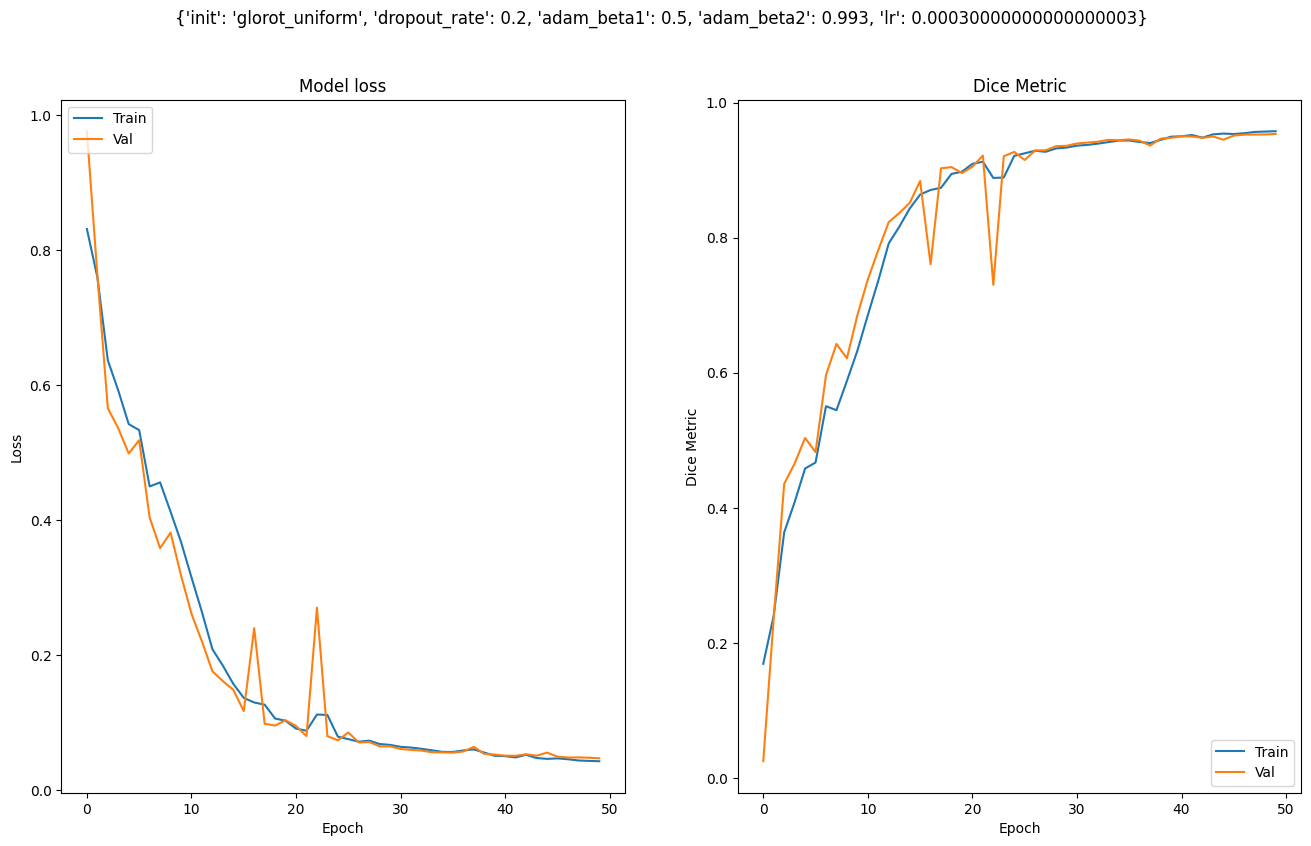

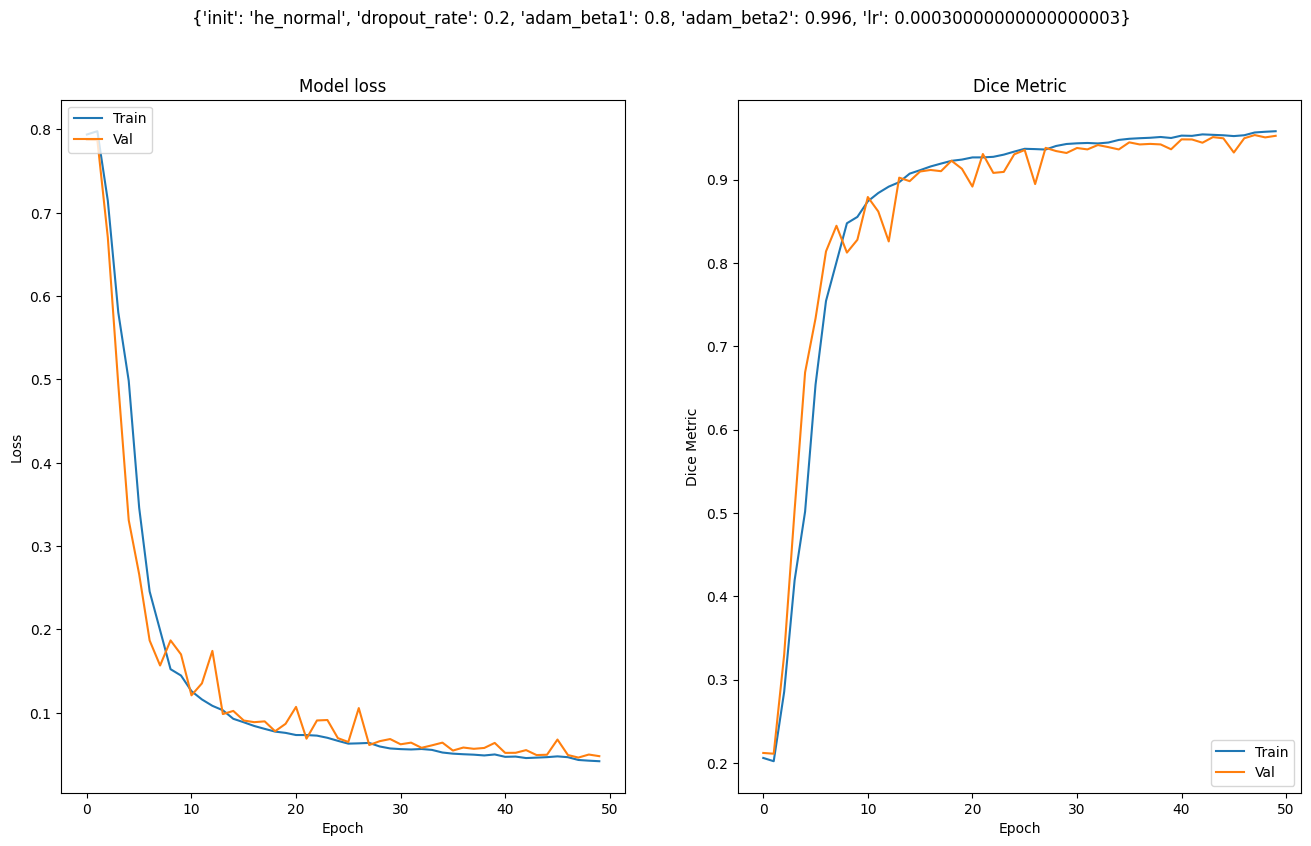

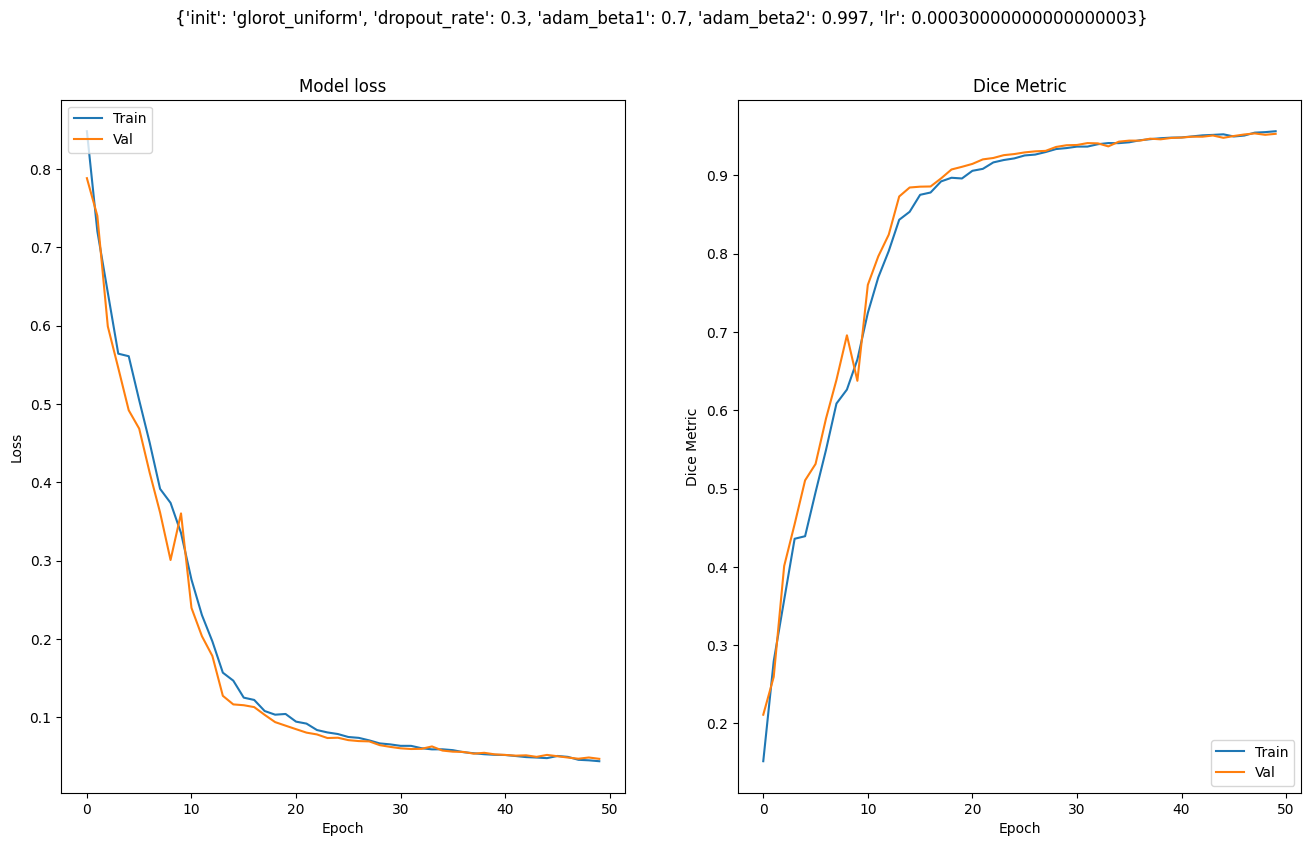

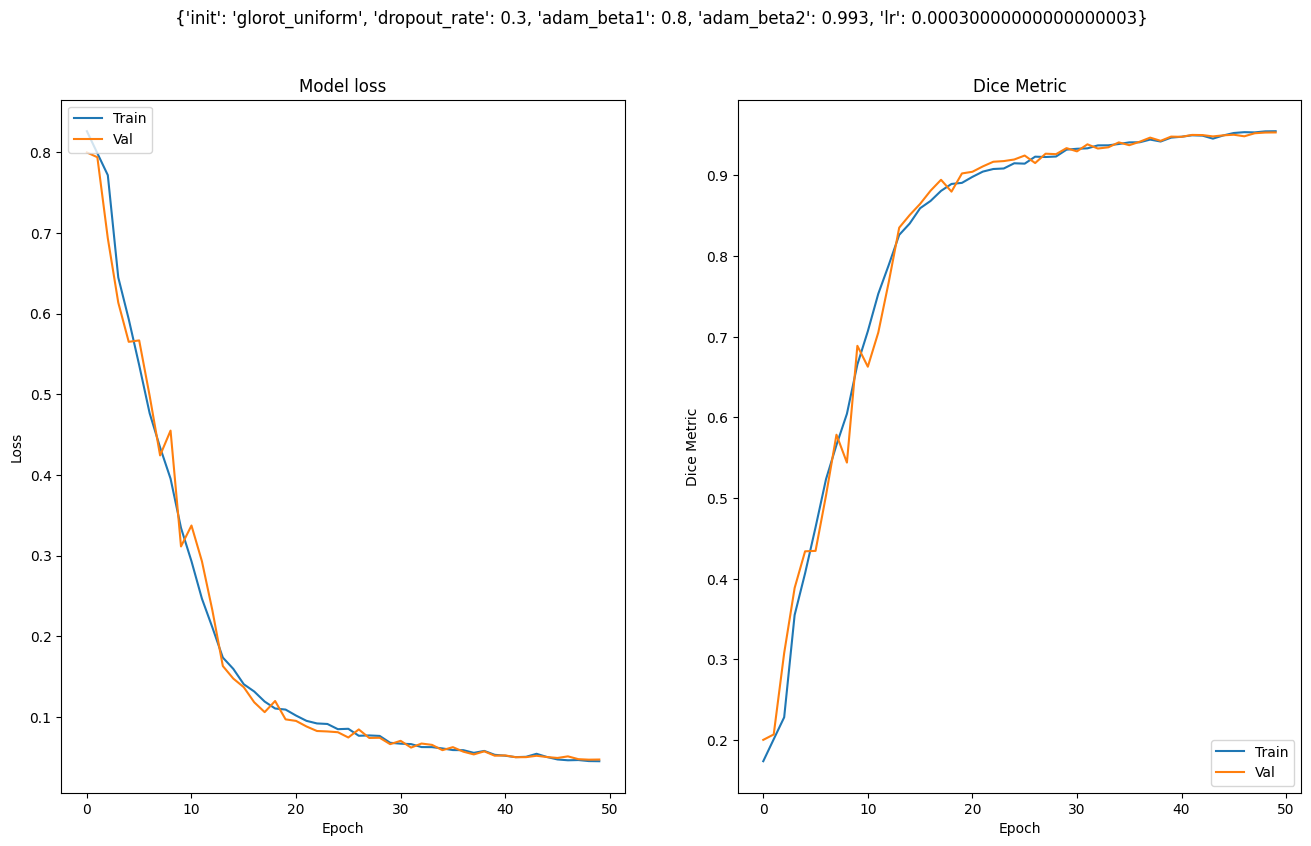

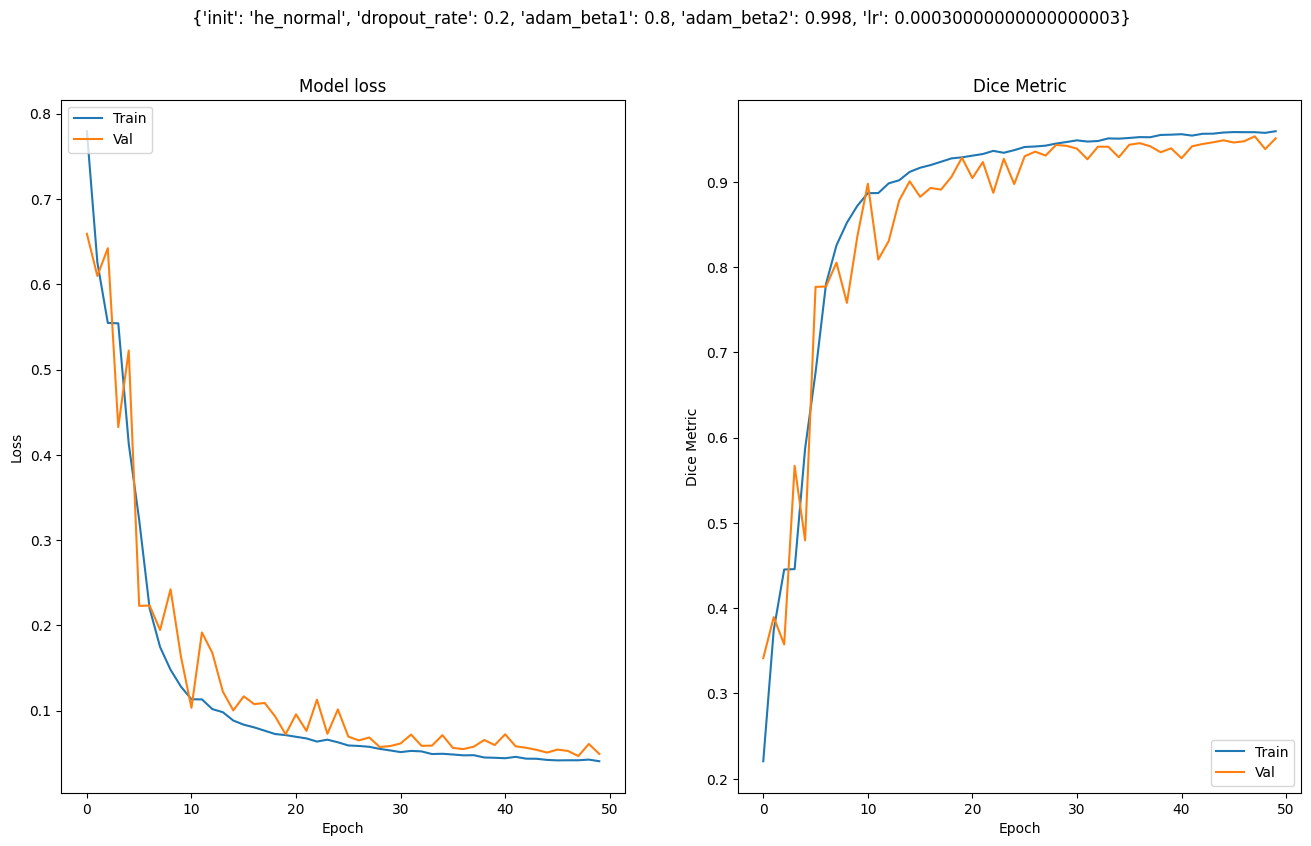

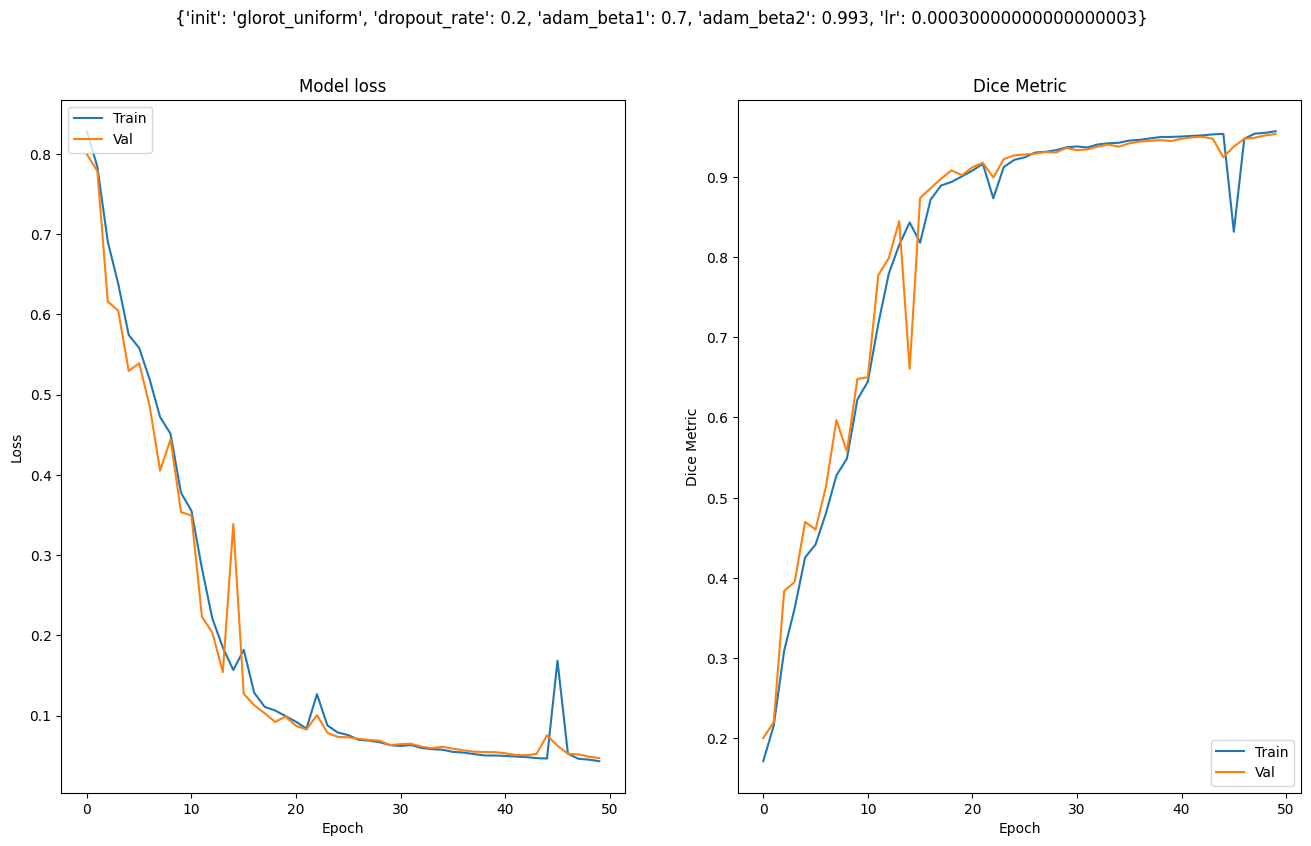

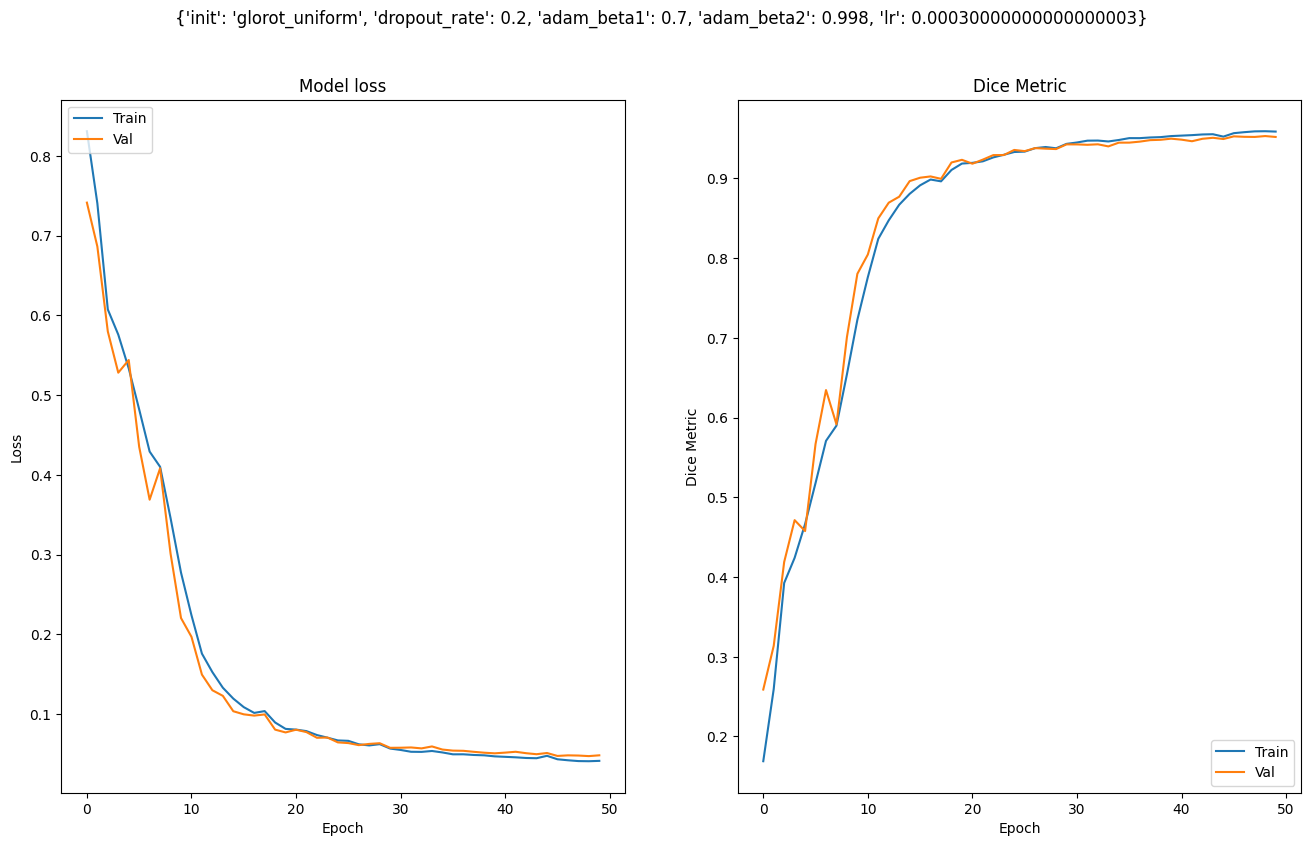

In [29]:
training_results = sorted(combinations_dicts, key=lambda d: max(d['history'].history['val_dice_metric'] if 'history' in d.keys() else [-1]), reverse=True)
for combo in training_results[:30]:
    labels = combo.copy()
    labels.pop('history')
    fig, axs = plt.subplots(1, 2, figsize=(16,9))
    fig.suptitle(labels)
    history = combo['history']
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[1].plot(history.history['dice_metric'])
    axs[1].plot(history.history['val_dice_metric'])
    axs[0].set_title(f"Model loss")
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'], loc='upper left')
    axs[1].set_title('Dice Metric')
    axs[1].set_ylabel('Dice Metric')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'], loc='lower right')
    plt.show()

In [49]:
plot_data = []
for combo in training_results[:20]:
    c = combo.copy()
    dice_metric = max(combo['history'].history['val_dice_metric'])
    c.pop('history')
    c['dice_metric'] = dice_metric
    #print(f"{c} - {dice_metric}")
    plot_data.append(c)
    print(c)

{'init': 'glorot_uniform', 'dropout_rate': 0.3, 'adam_beta1': 0.8, 'adam_beta2': 0.991, 'lr': 0.00030000000000000003, 'dice_metric': 0.9574781060218811}
{'init': 'glorot_uniform', 'dropout_rate': 0.2, 'adam_beta1': 0.8, 'adam_beta2': 0.992, 'lr': 0.00030000000000000003, 'dice_metric': 0.9572945237159729}
{'init': 'he_normal', 'dropout_rate': 0.2, 'adam_beta1': 0.7, 'adam_beta2': 0.993, 'lr': 0.00030000000000000003, 'dice_metric': 0.9563837647438049}
{'init': 'glorot_uniform', 'dropout_rate': 0.3, 'adam_beta1': 0.7, 'adam_beta2': 0.996, 'lr': 0.00030000000000000003, 'dice_metric': 0.9562456011772156}
{'init': 'glorot_uniform', 'dropout_rate': 0.3, 'adam_beta1': 0.8, 'adam_beta2': 0.994, 'lr': 0.00030000000000000003, 'dice_metric': 0.9561899304389954}
{'init': 'he_normal', 'dropout_rate': 0.2, 'adam_beta1': 0.6, 'adam_beta2': 0.991, 'lr': 0.00030000000000000003, 'dice_metric': 0.9558175206184387}
{'init': 'glorot_uniform', 'dropout_rate': 0.2, 'adam_beta1': 0.9, 'adam_beta2': 0.991, 'lr'

In [1]:
plot_data = [
    {'init': 'glorot_uniform', 'dropout_rate': 0.3, 'adam_beta1': 0.8, 'adam_beta2': 0.991, 'lr': 0.00030000000000000003, 'dice_metric': 0.9574781060218811},
    {'init': 'glorot_uniform', 'dropout_rate': 0.2, 'adam_beta1': 0.8, 'adam_beta2': 0.992, 'lr': 0.00030000000000000003, 'dice_metric': 0.9572945237159729},
    {'init': 'he_normal', 'dropout_rate': 0.2, 'adam_beta1': 0.7, 'adam_beta2': 0.993, 'lr': 0.00030000000000000003, 'dice_metric': 0.9563837647438049},
    {'init': 'glorot_uniform', 'dropout_rate': 0.3, 'adam_beta1': 0.7, 'adam_beta2': 0.996, 'lr': 0.00030000000000000003, 'dice_metric': 0.9562456011772156},
    {'init': 'glorot_uniform', 'dropout_rate': 0.3, 'adam_beta1': 0.8, 'adam_beta2': 0.994, 'lr': 0.00030000000000000003, 'dice_metric': 0.9561899304389954},
    {'init': 'he_normal', 'dropout_rate': 0.2, 'adam_beta1': 0.6, 'adam_beta2': 0.991, 'lr': 0.00030000000000000003, 'dice_metric': 0.9558175206184387},
    {'init': 'glorot_uniform', 'dropout_rate': 0.2, 'adam_beta1': 0.9, 'adam_beta2': 0.991, 'lr': 0.00030000000000000003, 'dice_metric': 0.955807626247406},
    {'init': 'glorot_uniform', 'dropout_rate': 0.2, 'adam_beta1': 0.9, 'adam_beta2': 0.997, 'lr': 0.00030000000000000003, 'dice_metric': 0.955592155456543},
    {'init': 'glorot_uniform', 'dropout_rate': 0.2, 'adam_beta1': 0.9, 'adam_beta2': 0.995, 'lr': 0.00030000000000000003, 'dice_metric': 0.9552703499794006},
    {'init': 'glorot_uniform', 'dropout_rate': 0.2, 'adam_beta1': 0.6, 'adam_beta2': 0.994, 'lr': 0.00030000000000000003, 'dice_metric': 0.9551003575325012},
    {'init': 'glorot_uniform', 'dropout_rate': 0.2, 'adam_beta1': 0.8, 'adam_beta2': 0.991, 'lr': 0.00030000000000000003, 'dice_metric': 0.9549126029014587},
    {'init': 'glorot_uniform', 'dropout_rate': 0.2, 'adam_beta1': 0.8, 'adam_beta2': 0.994, 'lr': 0.00030000000000000003, 'dice_metric': 0.9548751711845398},
    {'init': 'he_normal', 'dropout_rate': 0.2, 'adam_beta1': 0.5, 'adam_beta2': 0.991, 'lr': 0.00030000000000000003, 'dice_metric': 0.9548394083976746},
    {'init': 'he_normal', 'dropout_rate': 0.2, 'adam_beta1': 0.7, 'adam_beta2': 0.991, 'lr': 0.00030000000000000003, 'dice_metric': 0.9546578526496887},
    {'init': 'glorot_uniform', 'dropout_rate': 0.3, 'adam_beta1': 0.9, 'adam_beta2': 0.993, 'lr': 0.00030000000000000003, 'dice_metric': 0.9545062184333801},
    {'init': 'he_normal', 'dropout_rate': 0.2, 'adam_beta1': 0.9, 'adam_beta2': 0.992, 'lr': 0.00030000000000000003, 'dice_metric': 0.9539551734924316},
    {'init': 'glorot_uniform', 'dropout_rate': 0.3, 'adam_beta1': 0.9, 'adam_beta2': 0.997, 'lr': 0.00030000000000000003, 'dice_metric': 0.9538684487342834},
    {'init': 'glorot_uniform', 'dropout_rate': 0.3, 'adam_beta1': 0.8, 'adam_beta2': 0.992, 'lr': 0.00030000000000000003, 'dice_metric': 0.9538471102714539},
    {'init': 'glorot_uniform', 'dropout_rate': 0.3, 'adam_beta1': 0.9, 'adam_beta2': 0.991, 'lr': 0.00030000000000000003, 'dice_metric': 0.9537174701690674},
    {'init': 'glorot_uniform', 'dropout_rate': 0.2, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'lr': 0.00030000000000000003, 'dice_metric': 0.9537141919136047}
]


In [2]:
import pandas as pd
import plotly.express as px

# Create a DataFrame
df = pd.DataFrame(plot_data)

# Convert the categorical 'init' column to numerical values
df['init'] = df['init'].astype('category').cat.codes

# Plotting parallel coordinates plot
fig = px.parallel_coordinates(df, 
                              color="dice_metric",
                              dimensions=['init', 'dropout_rate', 'adam_beta1', 'adam_beta2', 'dice_metric'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=0.95)

# Show the plot
fig.show()
